# Analyse the AW shape in CREG025.L75 experiments

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()

%matplotlib inline

In [2]:
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

import fsspec
import json
import intake

import dask
import dask_hpcconfig
from distributed import Client
from dask.distributed import Client, LocalCluster


In [3]:
cluster = dask_hpcconfig.cluster("datarmor", **{})
client = Client(cluster)
cluster.scale(jobs=1)

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [1]:
import gsw as gsw

ImportError: No module named gsw

>> Function definition START

In [4]:
def Arc_Bat(ztype='isol1000') :

        locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
        locfile='bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['Bathymetry'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [5]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=1
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return

In [6]:
def awtmax_depth (temp,sal,zdim,deptht,ztime=None, zmask=None):
    #%%time 
    if ztime != None : 
        mask = (sal > 33.5) 
        ztemp = temp.where(mask)

    #%%time 
    temp_filled = (ztemp.fillna(-10)).compute() #replace nans with absurd temperature values
    depth_map = temp_filled.argmax(dim=zdim,skipna=True) 
    temp_map = temp_filled.max(dim=zdim,skipna=True)

    temp_map=temp_map.where(temp_map != -10)
    depth_map=depth_map.where(depth_map != -10)
    #print(zmask.shape)
    if zmask.any != None : depth_map=depth_map.where(zmask != 0)
    
    # Need to get now the true depth, not the index
    ind_awdepth=np.int32(depth_map)
    new_depth=[]
    for it in ind_awdepth.flat:
        if it < 0 :
            new_depth.append(-999)
        else:
            new_depth.append(deptht[it])

    true_depth=np.array(new_depth)
    true_depth=np.where(true_depth == -999,np.nan, true_depth)
    # Hard coded dimensions of the CREG12.L75 configuration 
    #reshape_true_depth=np.reshape(true_depth,(1801, 1580))
    # Hard coded dimensions of the CREG025.L75 configuration 
    if ztime != None : 
        reshape_true_depth=np.reshape(true_depth,(ztime,603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['time_counter','y','x'])
    else: 
        reshape_true_depth=np.reshape(true_depth,(603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['y','x'])

    
    return temp_map, final_true_depth

In [7]:
def ArcticZoom_map(zyear,infld,zmy_min=-10,zmy_max=10,CASE=None,zmap='Spectral_r'):
    # Plot the 12 months of a given year 

    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        if i < 9: 
            mm='0'+str(i+1) 
        else : 
            mm=str(i+1)
        infld.isel(time_counter=i).isel(y=slice(300,550),x=slice(200,400)).plot(ax=ax,vmin=zmy_min,vmax=zmy_max,cmap=zmap)   
        #ds_ICE['siconc'].sel(time_counter=str(year)+'-'+mm).isel(y=slice(300,550),x=slice(200,400))[0,:,:].plot.contour(ax=ax,levels=[0.15],colors='g')   
        fieldbat['bathy_meter'].isel(t=0,y=slice(300,550),x=slice(200,400)).plot.contour(ax=ax,levels=[500.,2000.],colors='k',alpha=0.8)
        # The indices in the following are taken in the new framework set by the slices just above
        zbx_SVAL={'name':'SVA','lon_min':125,'lon_max':125,'lat_min':50,'lat_max':50}
        zbx_BANN={'name':'BAN','lon_min':147,'lon_max':147,'lat_min':100,'lat_max':100}
        zbx_AANN={'name':'AAN','lon_min':154,'lon_max':154,'lat_min':125,'lat_max':125}
        zbx_KARA={'name':'KAR','lon_min':155,'lon_max':155,'lat_min':150,'lat_max':150}
        zbx_ULAP={'name':'ULA','lon_min':164,'lon_max':164,'lat_min':178,'lat_max':178}
        zbx_LAPT={'name':'LAP','lon_min':155,'lon_max':155,'lat_min':200,'lat_max':200}
        zbx_BGYR={'name':'LAP','lon_min':10,'lon_max':10,'lat_min':175,'lat_max':175}
        All_box=[zbx_SVAL,zbx_BANN,zbx_AANN,zbx_KARA,zbx_ULAP,zbx_LAPT,zbx_BGYR]
        for box in All_box:
            ax.scatter(box['lon_min'],box['lat_min'],20,marker='o', color='r')

        ax.set_title(CASE+'  month:'+str(zyear)+mm)
    return

In [8]:
# Define a function used to clean data from the Monitoring 
def clean_AM_AWtmax_depth(fldtoclean,tmask2D):
    fldtoclean=xr.where(tmask2D==0., np.nan,fldtoclean)
    fldtoclean=xr.where(fldtoclean >=999., np.nan,fldtoclean)
    return fldtoclean

>> Function definition END

# CREG025.L75  Grid

In [9]:
GRIDPATH='/home1/scratch/ctalandi/CREG025.L75/CREG025.L75-I/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG025.L75_byte_mask.nc')
ds_grd
tmask2D=ds_grd['tmask'].isel(z=0,t=0)

# CREG025.L75  Bathymetry

In [10]:
locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/GRID/'
locfile='CREG025.L75_domain_cfg.nc'
fieldbat=xr.open_dataset(locpath+locfile)

# Read the full years input Data processed by the Arctic Monitoring

In [59]:
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-I/'
filein='CREG025.L75-NEMO420_OCEinit_TS.nc'
ds_init=xr.open_dataset(DATA_PATH+filein,drop_variables=["x", "y"])
ds_init

filein='CREG025.L75-NEMO420DIN_OCEinit_gridT_SM10.nc'
ds_icor=xr.open_dataset(DATA_PATH+filein,drop_variables=["x", "y"])
ds_icor

<xarray.Dataset>
Dimensions:       (nav_lev: 75, time_counter: 1, y: 603, x: 528)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float32 0.0
Dimensions without coordinates: y, x
Data variables: (12/20)
    votemper      (time_counter, nav_lev, y, x) float64 ...
    vosaline      (time_counter, nav_lev, y, x) float64 ...
    sossheig      (time_counter, y, x) float64 ...
    vozocrtx      (time_counter, nav_lev, y, x) float64 ...
    vomecrty      (time_counter, nav_lev, y, x) float64 ...
    vovecrtz      (time_counter, nav_lev, y, x) float64 ...
    ...            ...
    soshfldo      (time_counter, y, x) float64 ...
    soicecov      (time_counter, y, x) float64 ...
    sozotaux      (time_counter, y, x) float64 ...
    sometauy      (time_counter, y, x) float64 ...
    vovvldep      (time_counter, nav_lev, y, x) float64 ...
    vovvle3t      (time_counter, nav_lev, y, x) float64 ...

In [13]:
print(xr.where(ds_init['nav_lev']=200.,method'nearest'))

<xarray.DataArray 'nav_lev' (nav_lev: 75)>
array([5.057600e-01, 1.555855e+00, 2.667682e+00, 3.856280e+00, 5.140361e+00,
       6.543034e+00, 8.092519e+00, 9.822750e+00, 1.177368e+01, 1.399104e+01,
       1.652532e+01, 1.942980e+01, 2.275762e+01, 2.655830e+01, 3.087456e+01,
       3.574020e+01, 4.118002e+01, 4.721189e+01, 5.385064e+01, 6.111284e+01,
       6.902168e+01, 7.761116e+01, 8.692943e+01, 9.704131e+01, 1.080303e+02,
       1.200000e+02, 1.330758e+02, 1.474062e+02, 1.631645e+02, 1.805499e+02,
       1.997900e+02, 2.211412e+02, 2.448906e+02, 2.713564e+02, 3.008875e+02,
       3.338628e+02, 3.706885e+02, 4.117939e+02, 4.576256e+02, 5.086399e+02,
       5.652923e+02, 6.280260e+02, 6.972587e+02, 7.733683e+02, 8.566790e+02,
       9.474479e+02, 1.045854e+03, 1.151991e+03, 1.265861e+03, 1.387377e+03,
       1.516364e+03, 1.652568e+03, 1.795671e+03, 1.945296e+03, 2.101027e+03,
       2.262422e+03, 2.429025e+03, 2.600380e+03, 2.776039e+03, 2.955570e+03,
       3.138565e+03, 3.324641e+03

In [17]:
print(ds_init['nav_lev'].sel(nav_lev=200.,method='nearest'))

<xarray.DataArray 'nav_lev' ()>
array(199.78996, dtype=float32)
Coordinates:
    nav_lev  float32 199.8


In [57]:
CASE='NEMO420DIN'   ; freq='1m'

year=1979
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE+'-MEAN/'+freq+'/'
ds_DIN = xr.open_dataset(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m01.'+freq+'_gridW.nc')                           

In [56]:
LAPT_sec={'name':"Laptev" ,'jmin': 470,'jmax':520 ,'imin':340}

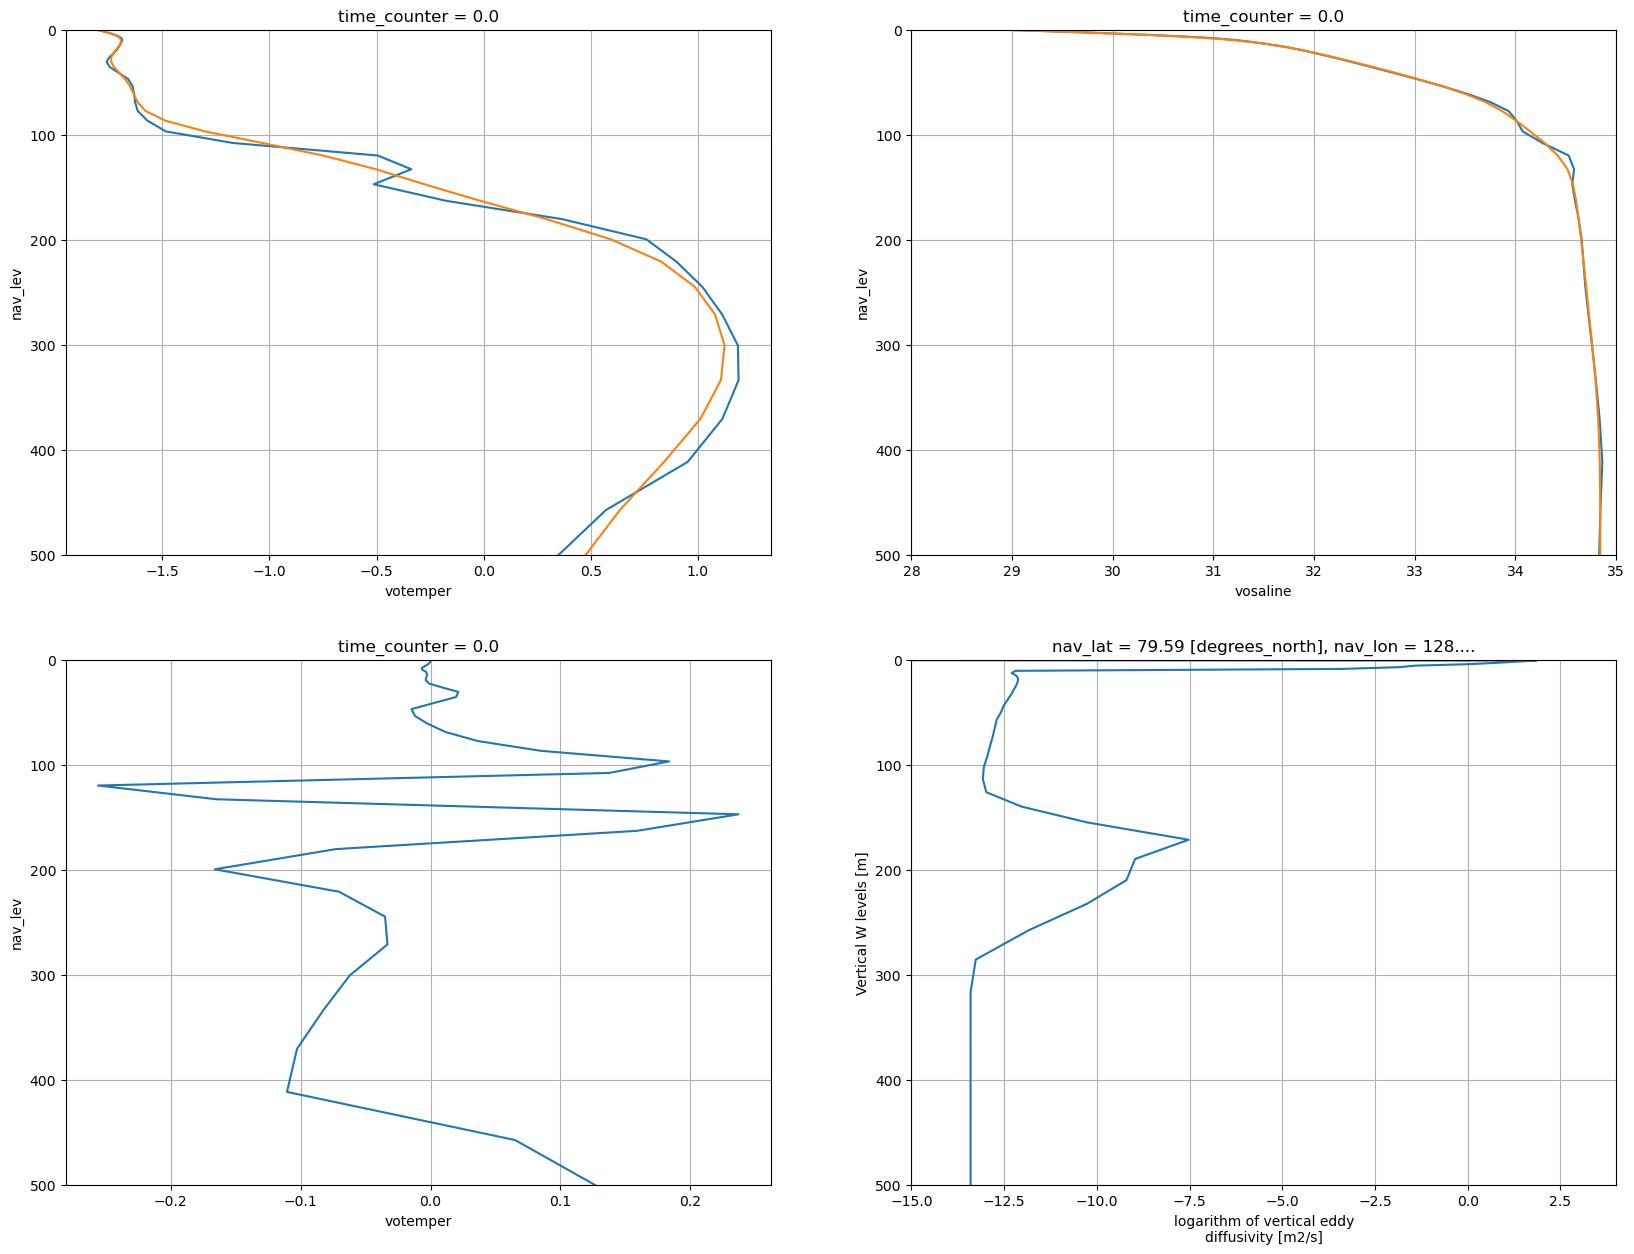

In [64]:
plt.figure(figsize=(20,15))

#loc_x=340  ;  loc_y=497
loc_x=340  ;  loc_y=490

plt.subplot(221)
ds_init['votemper'].isel(x=loc_x,y=loc_y).plot(y='nav_lev')
ds_icor['votemper'].isel(x=loc_x,y=loc_y).plot(y='nav_lev')
plt.ylim([500,0.])
plt.grid(True)

plt.subplot(222)
ds_init['vosaline'].isel(x=loc_x,y=loc_y).plot(y='nav_lev')
ds_icor['vosaline'].isel(x=loc_x,y=loc_y).plot(y='nav_lev')
plt.xlim([28,35])
plt.ylim([500,0.])
plt.grid(True)

plt.subplot(223)
(ds_icor['votemper']-ds_init['votemper']).isel(x=loc_x,y=loc_y).plot(y='nav_lev')
plt.ylim([500,0.])
plt.grid(True)

plt.subplot(224)
ds_DIN['logavt'].isel(x=loc_x,y=loc_y).plot(y='depthw')
#ds_DIN['logavt'].isel(x=340,y=slice(480,500)).plot(y='depthw',vmin=-15.,vmax=3.)
plt.xlim([-15,4])
plt.ylim([500,0.])
plt.grid(True)



# Assess the vertical mixing in the Eurasian Basin 

In [10]:
def moor_loc(All_box):
    for box in All_box:
            print(box)
            plt.scatter(box['lat_min'],box['lon_min'],3,marker='o', color='r')

In [31]:
ds_DIN

<xarray.Dataset>
Dimensions:               (y: 603, x: 528, depthw: 75, axis_nbounds: 2,
                           time_counter: 1)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * depthw                (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1979-01-16 12:00:00
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    depthw_bounds         (depthw, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds   (time_counter, axis_nbounds) object ...
    vovecrtz              (time_counter, depthw, y, x) float32 ...
    votkeavt              (time_counter, depthw, y, x) float32 ...
    e3w                   (time_counter, depthw, y, x) float32 ...
    logavt                (time_counter, depthw, y, x) float32 ...
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-NEMO420DIN-XIOS.1/...
    description:       ocean W grid variables
    title:             ocean W grid variables
    Conventions:       CF-1.6
    timeStamp:         2025-Mar-14 10:35:22 GMT
    uuid:              13448bec-ece4-4f62-8faa-8c244149cbfe
    start_date:        19790101
    output_frequency:  1mo
    CONFIG:            CREG025.L75
    CASE:              NEMO420DIN

1979
CPU times: user 7.74 s, sys: 9.25 s, total: 17 s
Wall time: 27.9 s


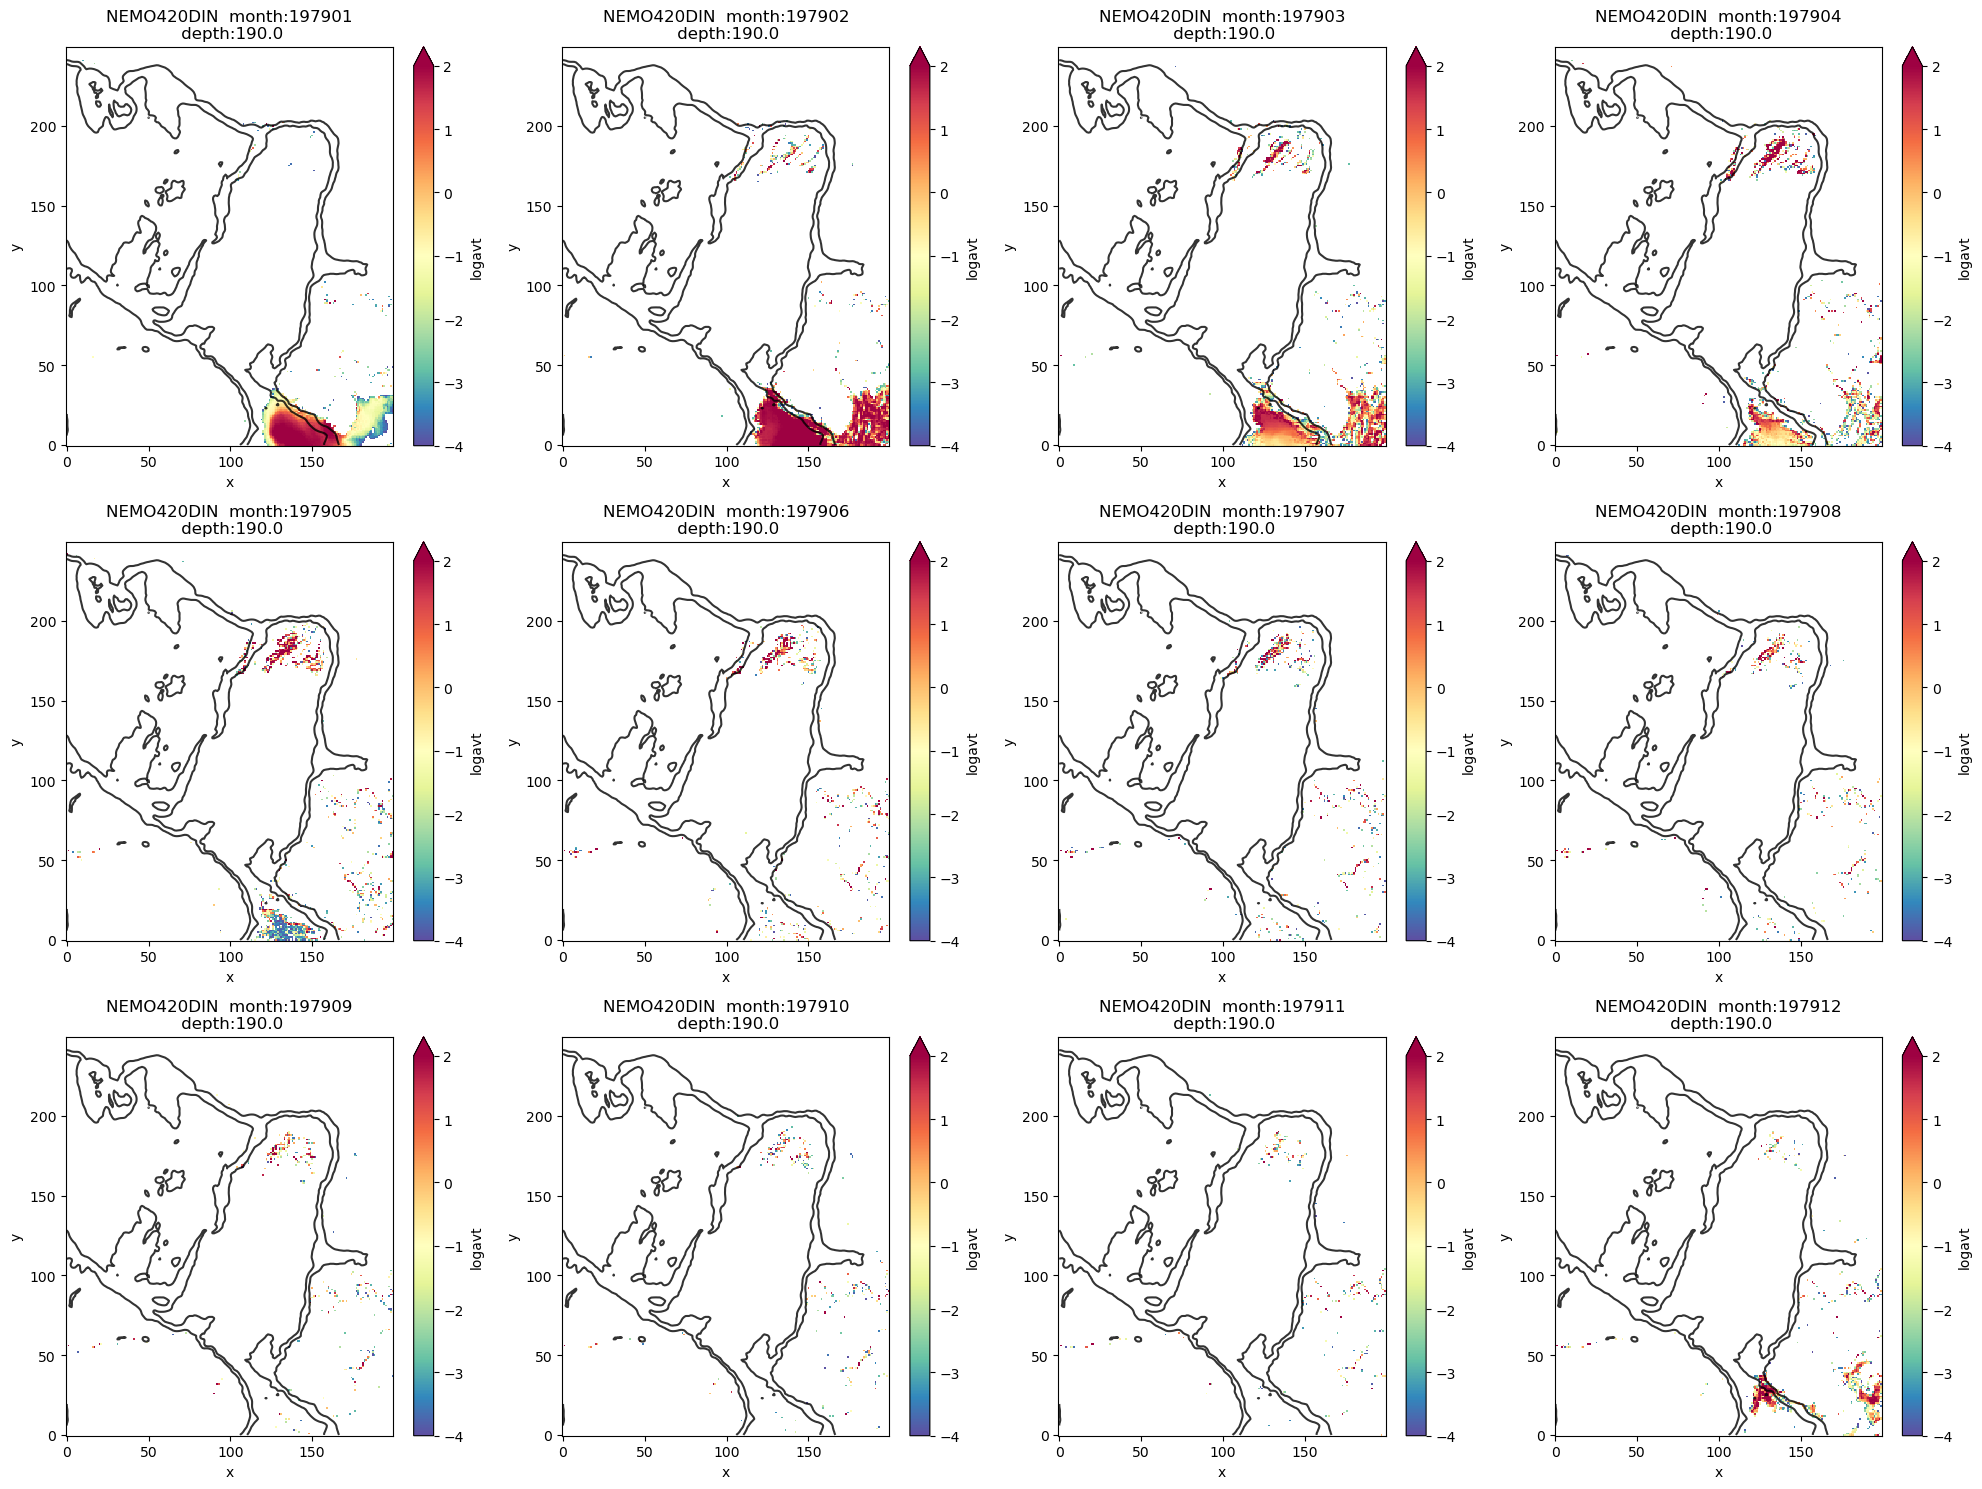

In [23]:
%%time 
ys=1979 ; ye=1979
zlocdepth=200
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    ds_AW = xr.concat([xr.open_dataset(f)[['logavt']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridW.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
    ds_AW=xr.where(ds_AW < -4., np.nan, ds_AW)
    
    my_min=-4 ; my_max=2.
    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        i+=1 
        if i < 10: 
            mm='0'+str(i) 
        else : 
            mm=str(i)
        ds_AW['logavt'].sel(time_counter=str(year)+'-'+mm).isel(y=slice(300,550),x=slice(200,400)).sel(depthw=zlocdepth,method='nearest').\
        plot(ax=ax,vmin=my_min,vmax=my_max,cmap='Spectral_r')   
        fieldbat['bathy_meter'].isel(t=0,y=slice(300,550),x=slice(200,400)).plot.contour(ax=ax,levels=[500.,2000.],colors='k',alpha=0.8)
        
        All_box=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR]
        for box in All_box:
            ax.scatter(box['lon_min'],box['lat_min'],20,marker='o', color='r')

        seldepthw=np.round(ds_AW['depthw'].sel(depthw=zlocdepth,method='nearest').data)
        ax.set_title(CASE+'  month:'+str(year)+mm+'\n depth:'+str(seldepthw))

    plt.tight_layout()
    if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_Zoom_LogAvt_z'+str(seldepthw)+'_y'+str(year)+'.png',dpi=300)

1979
CPU times: user 6.16 s, sys: 5.92 s, total: 12.1 s
Wall time: 1min 27s


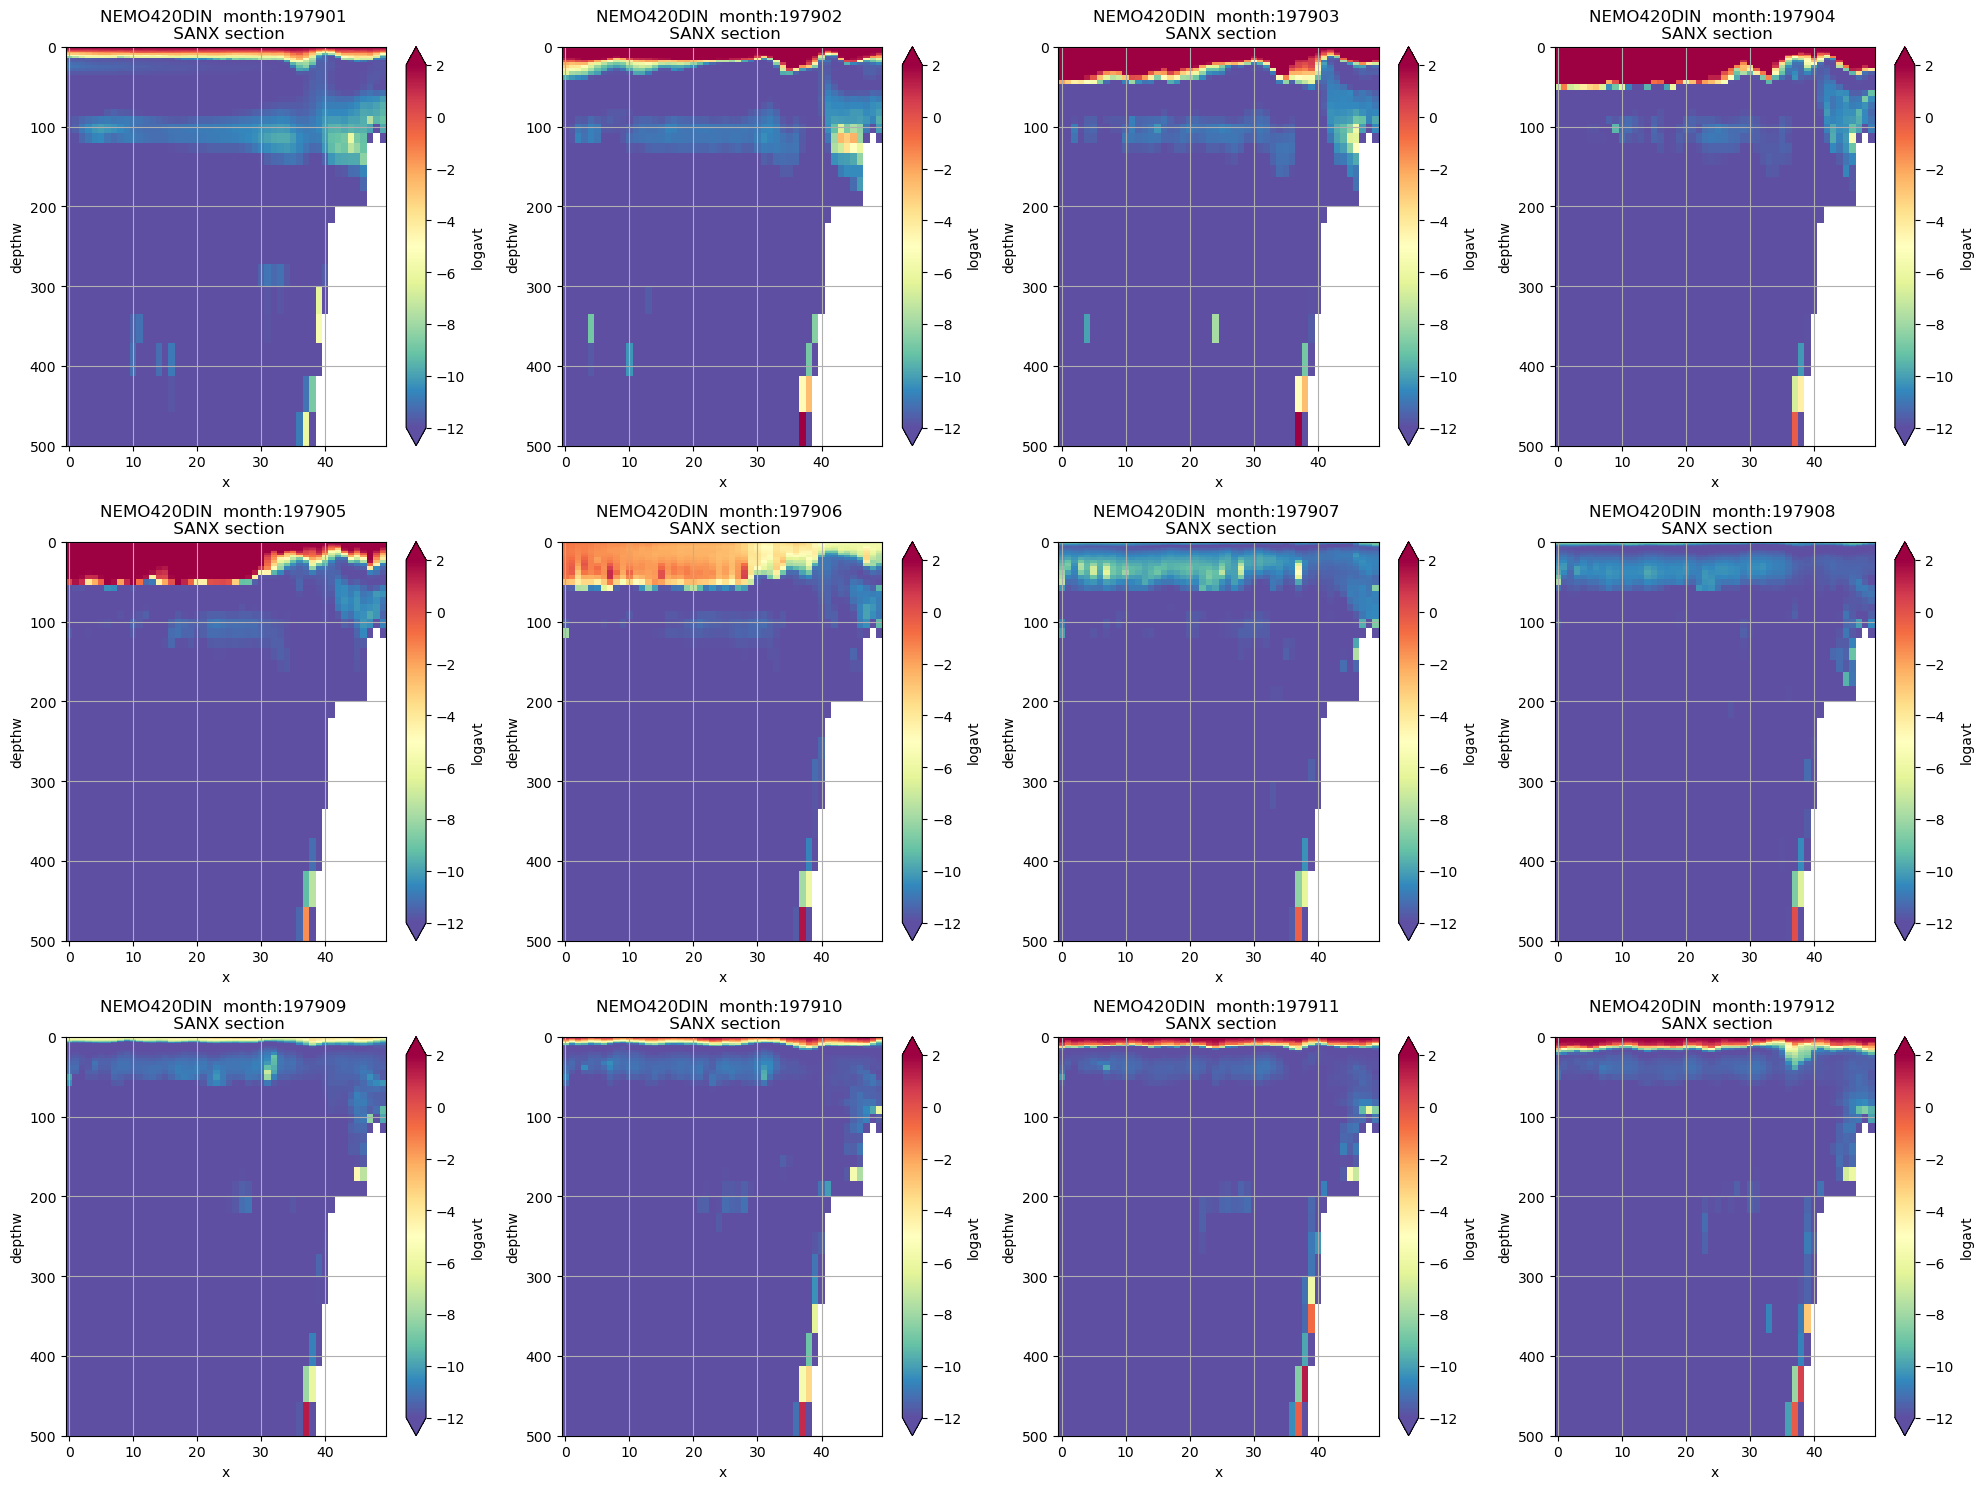

In [13]:
%%time 
ys=1979 ; ye=1979
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    ds_AW = xr.concat([xr.open_dataset(f)[['logavt']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridW.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
#    ds_AW=xr.where(ds_AW < -12., np.nan, ds_AW)
    
    my_min=-12 ; my_max=2.
    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        i+=1 
        if i < 10: 
            mm='0'+str(i) 
        else : 
            mm=str(i)
        ds_AW['logavt'].sel(time_counter=str(year)+'-'+mm).isel(y=425,x=slice(320,370)).\
        plot(y='depthw',ax=ax,vmin=my_min,vmax=my_max,cmap='Spectral_r')   
        
        ax.set_title(CASE+'  month:'+str(year)+mm+' \n SANX section')
        ax.set_ylim([500.,0.]) 
        ax.grid(True)

    plt.tight_layout()
    if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_Zoom_LogAvt_Sec_SANX_y'+str(year)+'.png',dpi=300)

1979
CPU times: user 5.51 s, sys: 2.4 s, total: 7.91 s
Wall time: 11.8 s


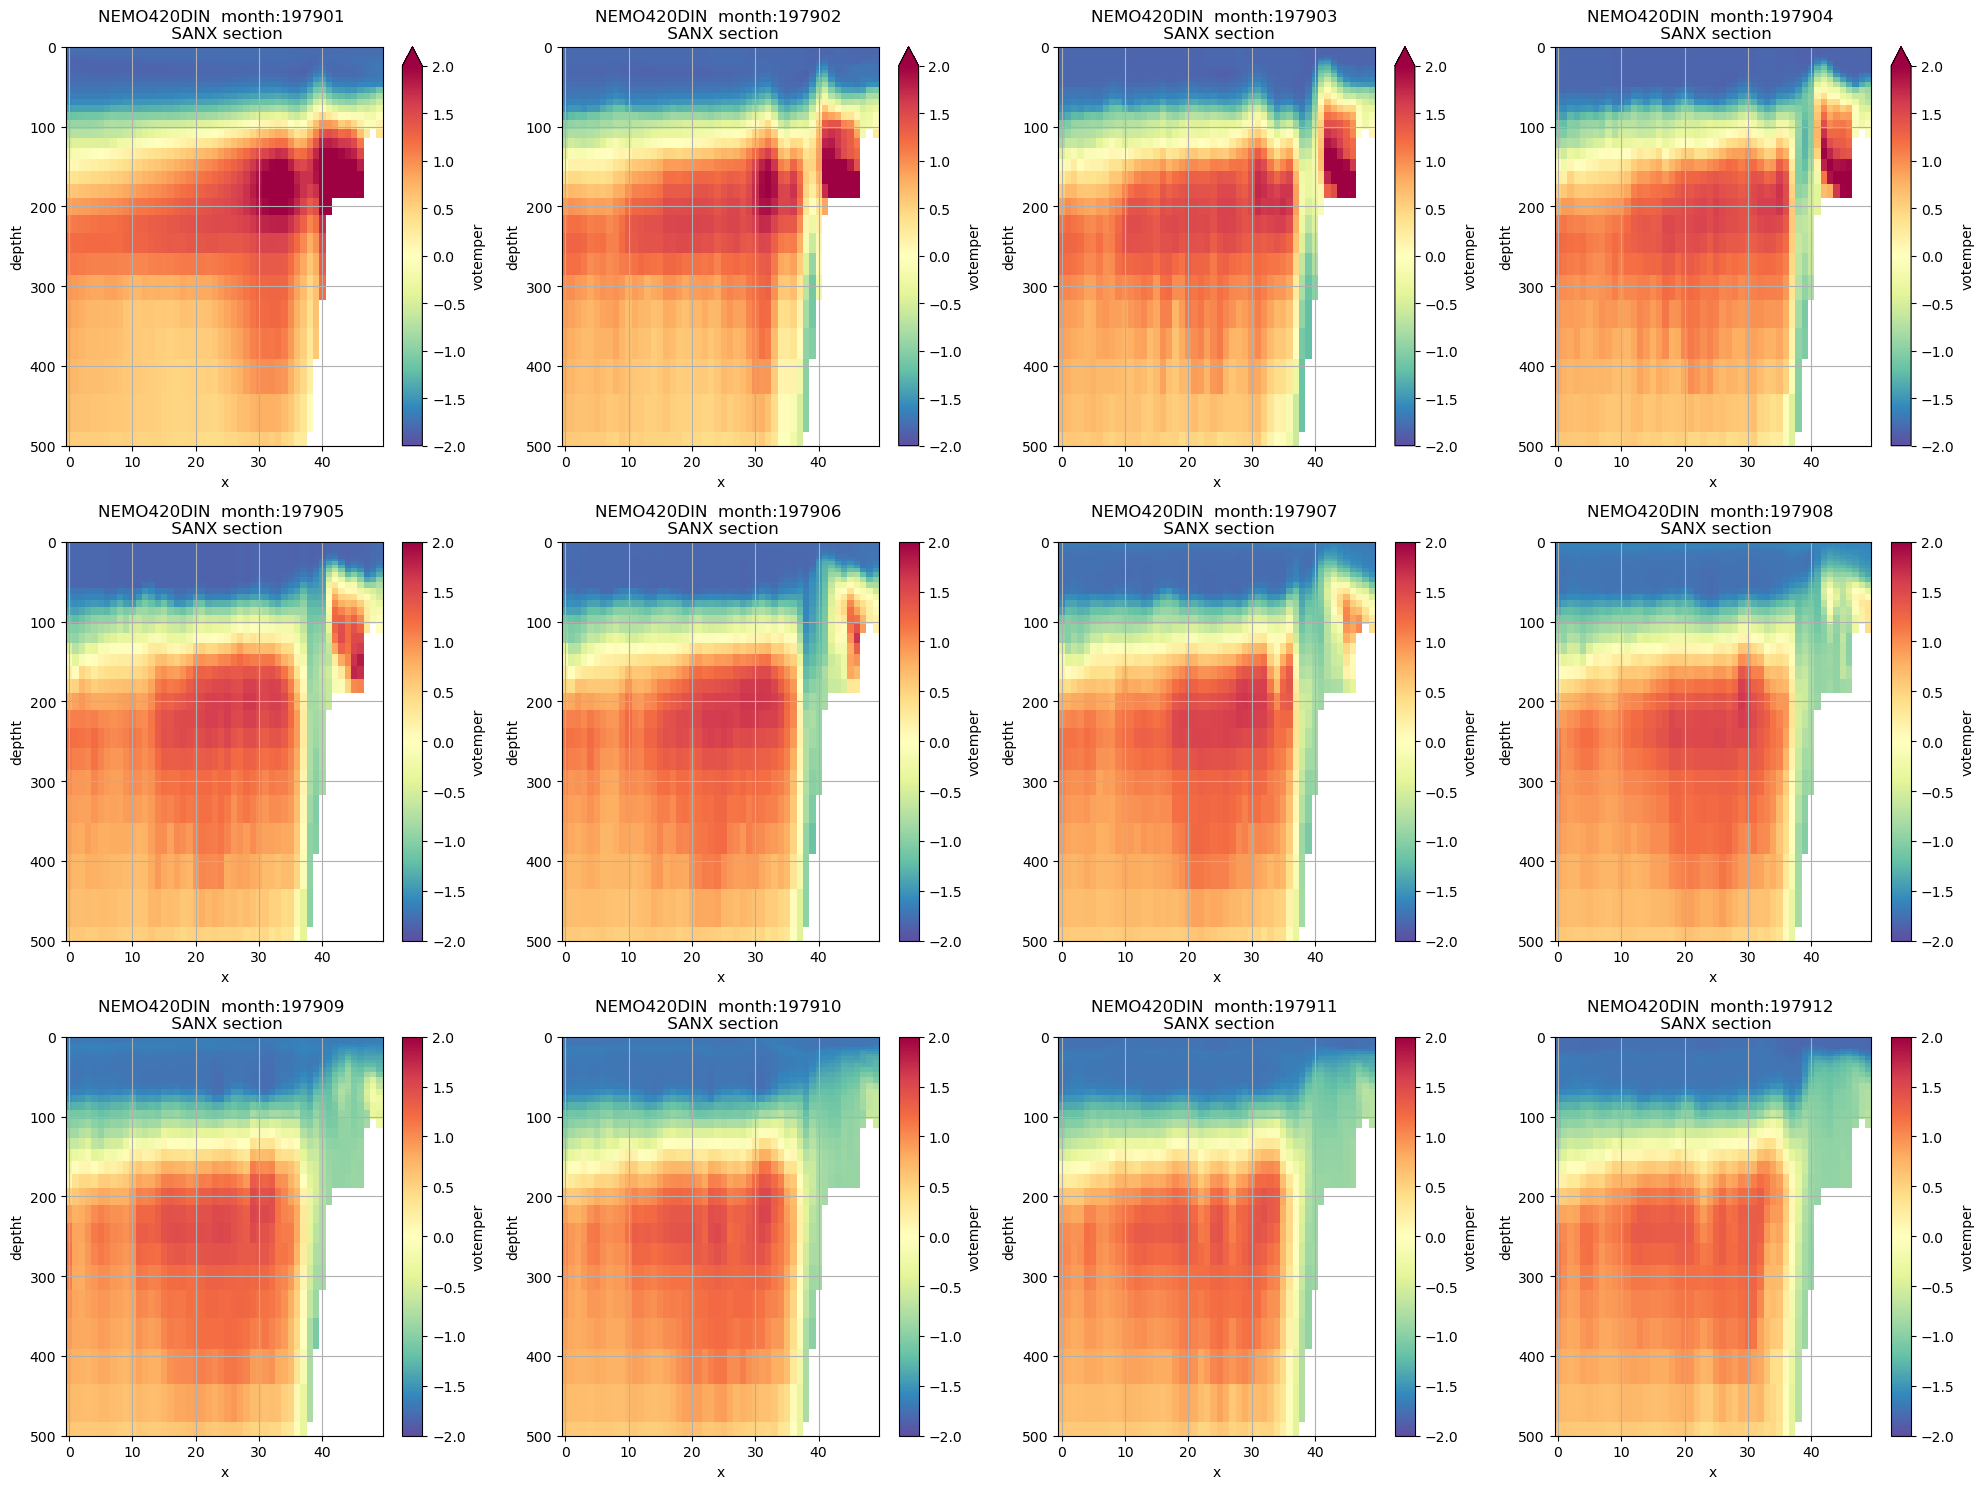

In [12]:
%%time 
ys=1979 ; ye=1979
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    ds_AW = xr.concat([xr.open_dataset(f)[['votemper']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridT.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
#    ds_AW=xr.where(ds_AW < -12., np.nan, ds_AW)
    
    my_min=-2 ; my_max=2.
    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        i+=1 
        if i < 10: 
            mm='0'+str(i) 
        else : 
            mm=str(i)
        ds_AW['votemper'].sel(time_counter=str(year)+'-'+mm).isel(y=425,x=slice(320,370)).\
        plot(y='deptht',ax=ax,vmin=my_min,vmax=my_max,cmap='Spectral_r')   
        
        ax.set_title(CASE+'  month:'+str(year)+mm+' \n SANX section')
        ax.set_ylim([500.,0.]) 
        ax.grid(True)

    plt.tight_layout()
    if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_Zoom_T_Sec_SANX_y'+str(year)+'.png',dpi=300)

> # Plot the differences with an onther exp.

1979
CPU times: user 9.96 s, sys: 8.94 s, total: 18.9 s
Wall time: 19.7 s


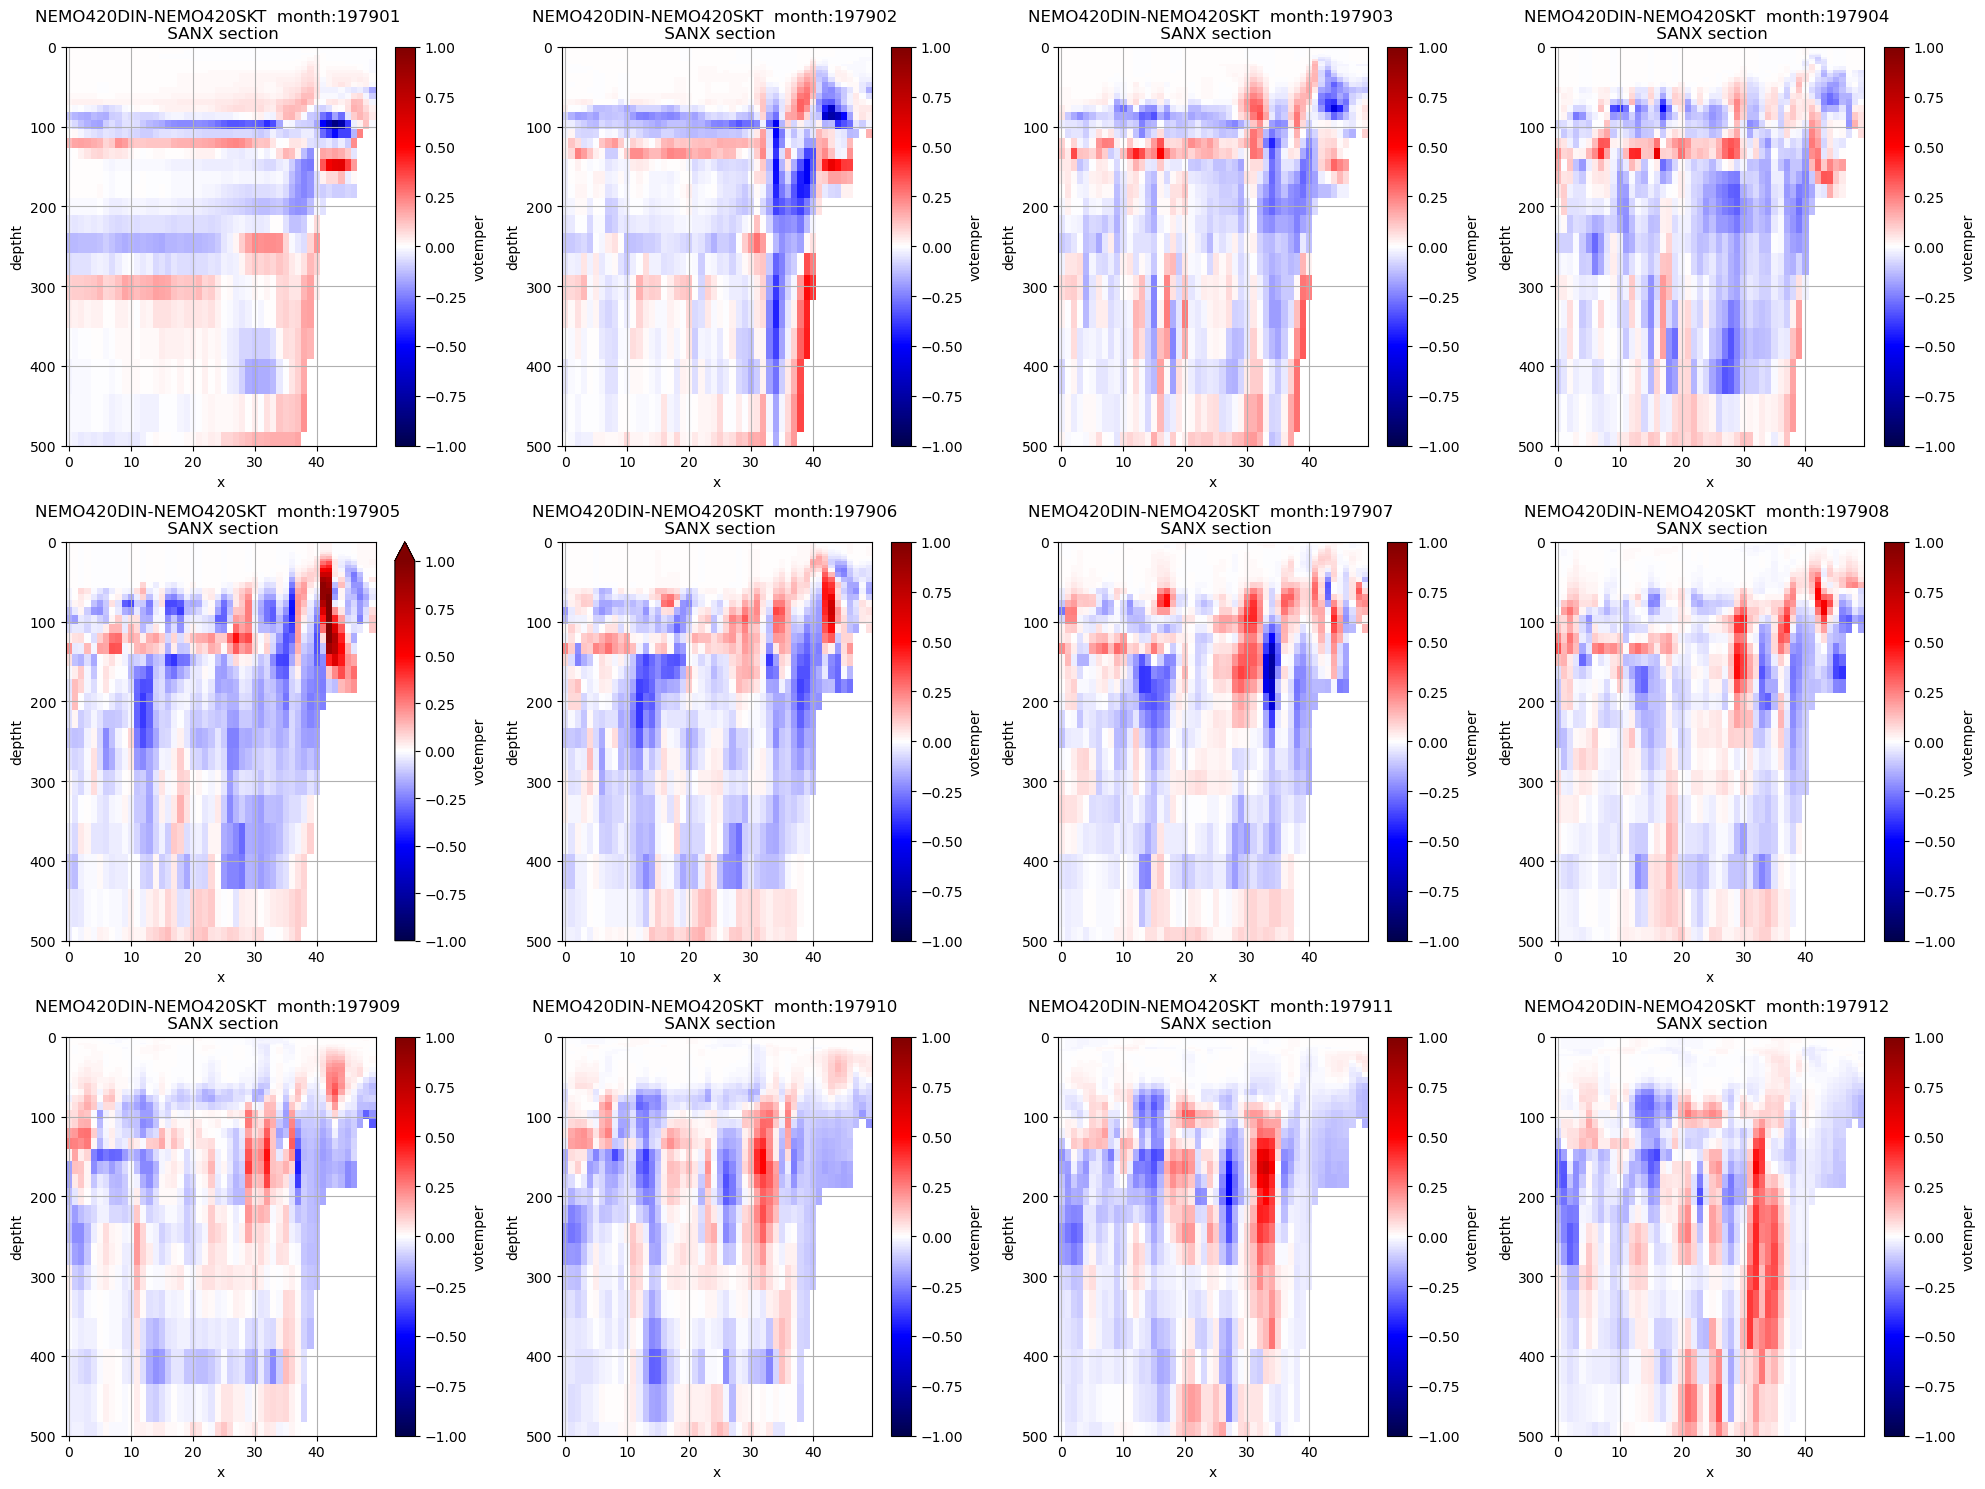

In [16]:
%%time 
CASE='NEMO420SKT'
CASE2='NEMO420DIN'

ys=1979 ; ye=1979
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE+'-MEAN/'+freq+'/'
    ds_AW = xr.concat([xr.open_dataset(f)[['votemper']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridT.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
#    ds_AW=xr.where(ds_AW < -12., np.nan, ds_AW)
    DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE2+'-MEAN/'+freq+'/'
    ds_AW2 = xr.concat([xr.open_dataset(f)[['votemper']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE2+'_y'+str(year)+'m??.'+freq+'_gridT.nc')],dim='time_counter')
    ds_AW2=xr.where(tmask2D == 0., np.nan, ds_AW2)
    
    my_min=-1 ; my_max=1.
    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        i+=1 
        if i < 10: 
            mm='0'+str(i) 
        else : 
            mm=str(i)
        (ds_AW2['votemper']-ds_AW['votemper']).sel(time_counter=str(year)+'-'+mm).isel(y=425,x=slice(320,370)).\
        plot(y='deptht',ax=ax,vmin=my_min,vmax=my_max,cmap='seismic')   
        
        ax.set_title(CASE2+'-'+CASE+'  month:'+str(year)+mm+' \n SANX section')
        ax.set_ylim([500.,0.]) 
        ax.grid(True)

    plt.tight_layout()
    if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE2+'-'+CASE+'_Zoom_T_Sec_SANX_y'+str(year)+'.png',dpi=300)

# Plot over time and at 50m/100m depth to see the seasonality of the Kz along the SANX section

In [26]:
%%time 
CASE='NEMO420SKT'
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE+'-MEAN/'+freq+'/'

ys=1979 ; ye=1981
tdep=150.
ds_log=None ; ds_conc=None ; ds_thi=None
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    ds_AW = xr.concat([xr.open_dataset(f)[['logavt']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridW.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
    ds_IC = xr.concat([xr.open_dataset(f)[['siconc','sivolu']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_icemod.nc')],dim='time_counter')
    ds_IC=xr.where(tmask2D == 0., np.nan, ds_IC)

    ds_logavt = ds_AW['logavt'].sel(depthw=tdep, method='nearest').isel(y=425, x=slice(320, 370))
    ds_sicon = ds_IC['siconc'].isel(y=425,x=slice(320,370))
    ds_sithi = ds_IC['sivolu'].isel(y=425,x=slice(320,370))
    
    if ds_log is None:
        ds_log = ds_logavt
        ds_sic = ds_sicon
        ds_thi = ds_sithi
    else:
        ds_log = xr.concat([ds_log, ds_logavt], dim='time_counter')
        ds_sic = xr.concat([ds_sic, ds_sicon], dim='time_counter')
        ds_thi = xr.concat([ds_thi, ds_sithi], dim='time_counter')        
    
    #ds_log=xr.concat([ds_log,ds_AW['logavt'].sel(depthw=100,method='nearest').isel(y=425,x=slice(320,370))],coords='all',dim='time_counter')
    #ds_con=xr.concat([ds_con,ds_IC['siconc'].isel(y=425,x=slice(320,370))],coords='all',dim='time_counter')
    #ds_thi=xr.concat([ds_thi,ds_ICE['sivolu'].isel(y=425,x=slice(320,370))],coords='all',dim='time_counter')
    

1979
1980
1981
CPU times: user 8.32 s, sys: 6.6 s, total: 14.9 s
Wall time: 15.3 s


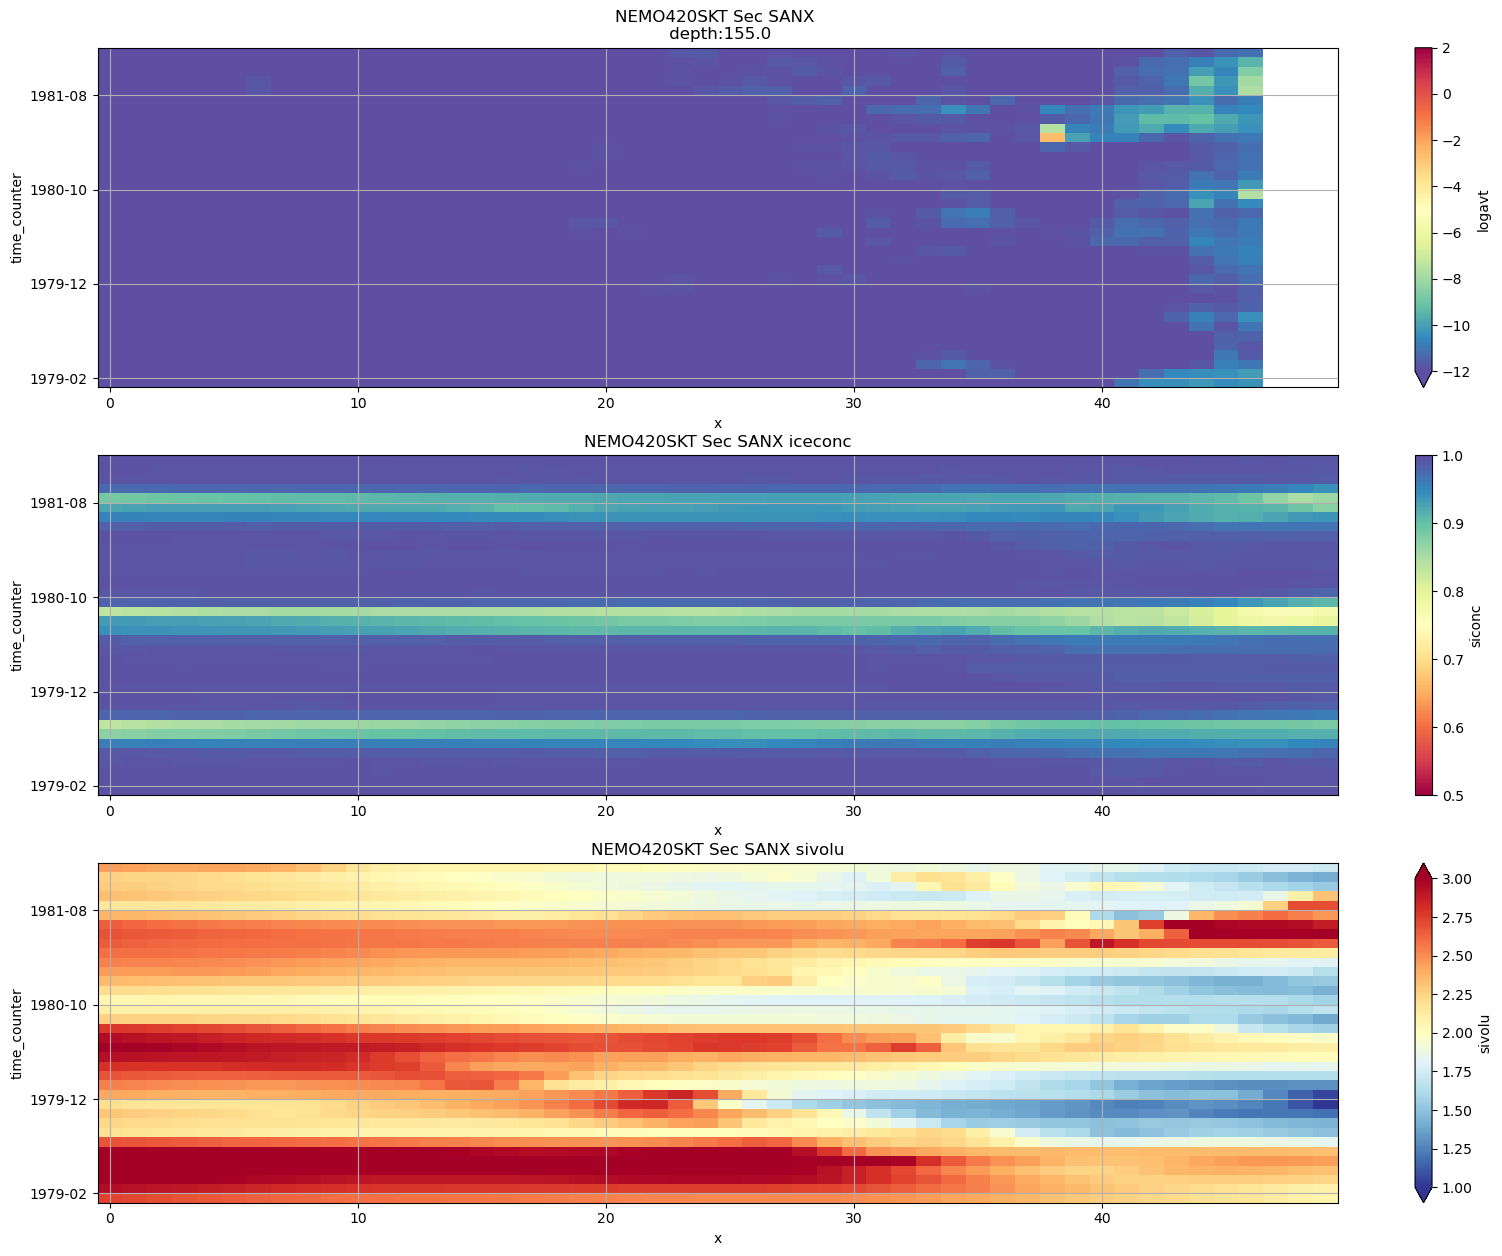

In [27]:
plt.figure(figsize=(20,15))

zdep=np.round(ds_AW['depthw'].sel(depthw=tdep,method='nearest').data)

plt.subplot(311)
ds_log_sorted = ds_log.sortby("time_counter")
my_min=-12 ; my_max=2.
ds_log_sorted.plot(y='time_counter',vmin=my_min,vmax=my_max,cmap='Spectral_r') 

plt.grid(True)
plt.title(CASE+' Sec SANX \n depth:'+str(zdep))

plt.subplot(312)
ds_sic_sorted = ds_sic.sortby("time_counter")
ds_sic_sorted.plot(y='time_counter',vmin=0.5,vmax=1.,cmap='Spectral') #,cmap='PuBu') 

plt.grid(True)
plt.title(CASE+' Sec SANX iceconc')

plt.subplot(313)
ds_thi_sorted = ds_thi.sortby("time_counter")
ds_thi_sorted.plot(y='time_counter',vmin=1.,vmax=3.,cmap='RdYlBu_r') 

plt.grid(True)
plt.title(CASE+' Sec SANX sivolu')

if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_Zoom_LogAvt_Sec_SANX_z'+str(np.round(zdep))+'_y'+str(ys)+str(ye)+'.png',dpi=300)

1979
CPU times: user 2.93 s, sys: 2.14 s, total: 5.07 s
Wall time: 9.42 s


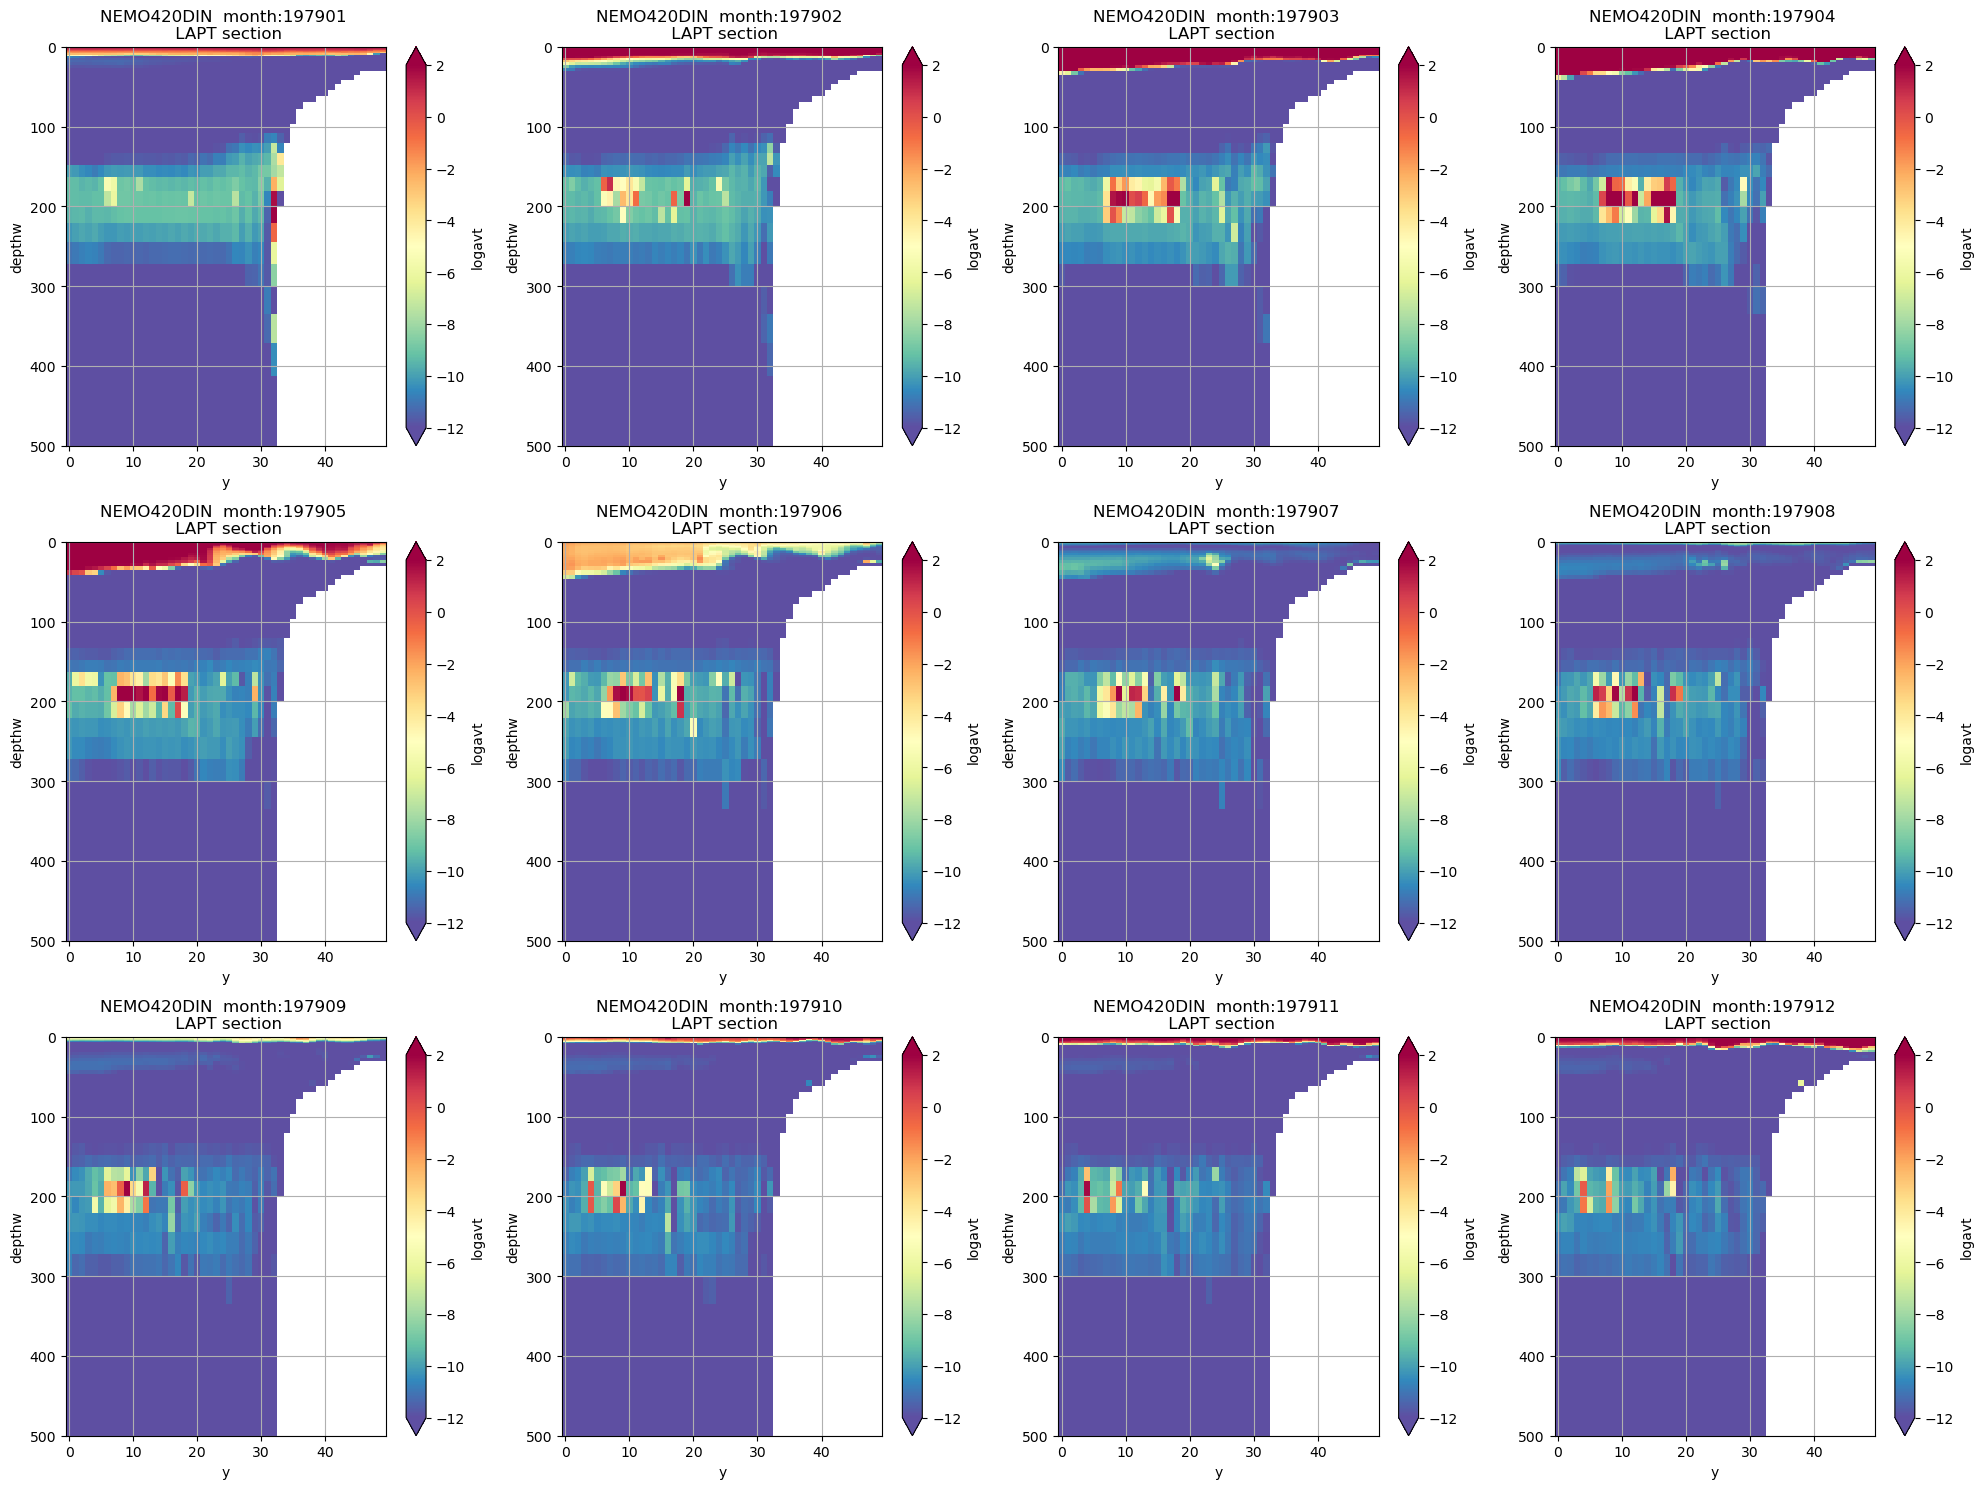

In [54]:
%%time 
CASE='NEMO420DIN'
ys=1979 ; ye=1979
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE+'-MEAN/'+freq+'/'
    ds_AW = xr.concat([xr.open_dataset(f)[['logavt']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridW.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
    
    my_min=-12 ; my_max=2.
    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        i+=1 
        if i < 10: 
            mm='0'+str(i) 
        else : 
            mm=str(i)
#        ds_AW['logavt'].sel(time_counter=str(year)+'-'+mm).isel(x=340,y=slice(470,520)).
        ds_AW['logavt'].sel(time_counter=str(year)+'-'+mm).isel(x=330,y=slice(470,520)).\
        plot(y='depthw',ax=ax,vmin=my_min,vmax=my_max,cmap='Spectral_r')   
        
        ax.set_title(CASE+'  month:'+str(year)+mm+' \n LAPT section')
        ax.set_ylim([500.,0.]) 
        ax.grid(True)

    plt.tight_layout()
    if False: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_Zoom_LogAvt_Sec_LAPT_y'+str(year)+'.png',dpi=300)

1979
CPU times: user 5.8 s, sys: 3.52 s, total: 9.32 s
Wall time: 1min 5s


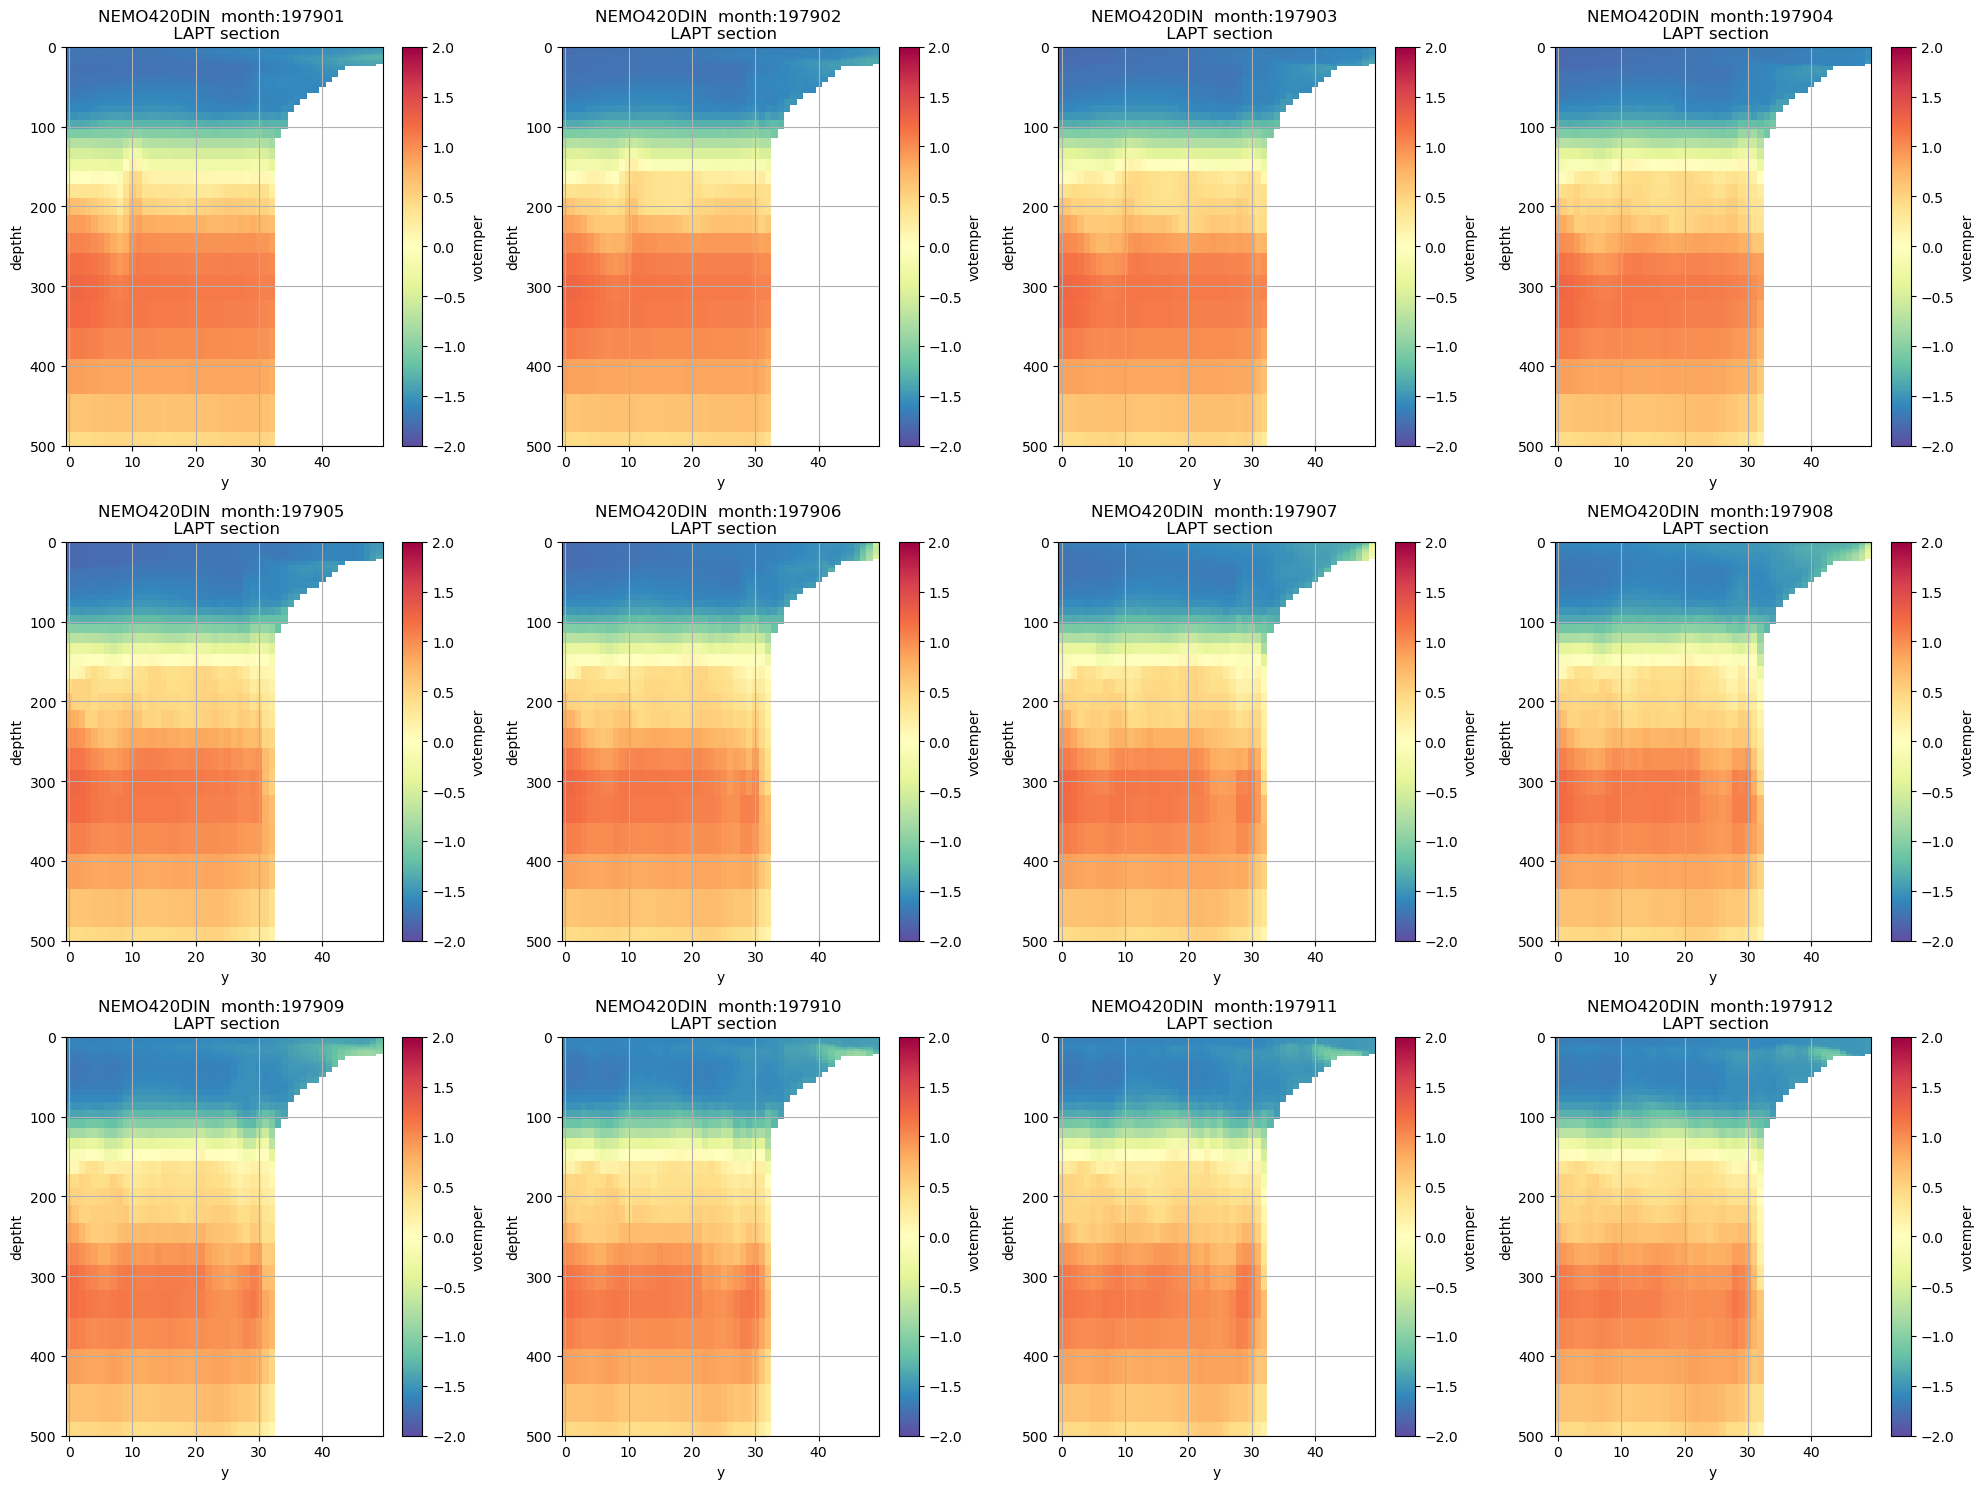

In [18]:
%%time 
ys=1979 ; ye=1979
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    ds_AW = xr.concat([xr.open_dataset(f)[['votemper']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridT.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
#    ds_AW=xr.where(ds_AW < -12., np.nan, ds_AW)
    
    my_min=-2 ; my_max=2.
    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        i+=1 
        if i < 10: 
            mm='0'+str(i) 
        else : 
            mm=str(i)
        ds_AW['votemper'].sel(time_counter=str(year)+'-'+mm).isel(x=340,y=slice(470,520)).\
        plot(y='deptht',ax=ax,vmin=my_min,vmax=my_max,cmap='Spectral_r')   
        
        ax.set_title(CASE+'  month:'+str(year)+mm+' \n LAPT section')
        ax.set_ylim([500.,0.]) 
        ax.grid(True)

    plt.tight_layout()
    if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_Zoom_T_Sec_LAPT_y'+str(year)+'.png',dpi=300)

> # Plot the differences with an onther exp.

1979
CPU times: user 9.7 s, sys: 7.29 s, total: 17 s
Wall time: 25.1 s


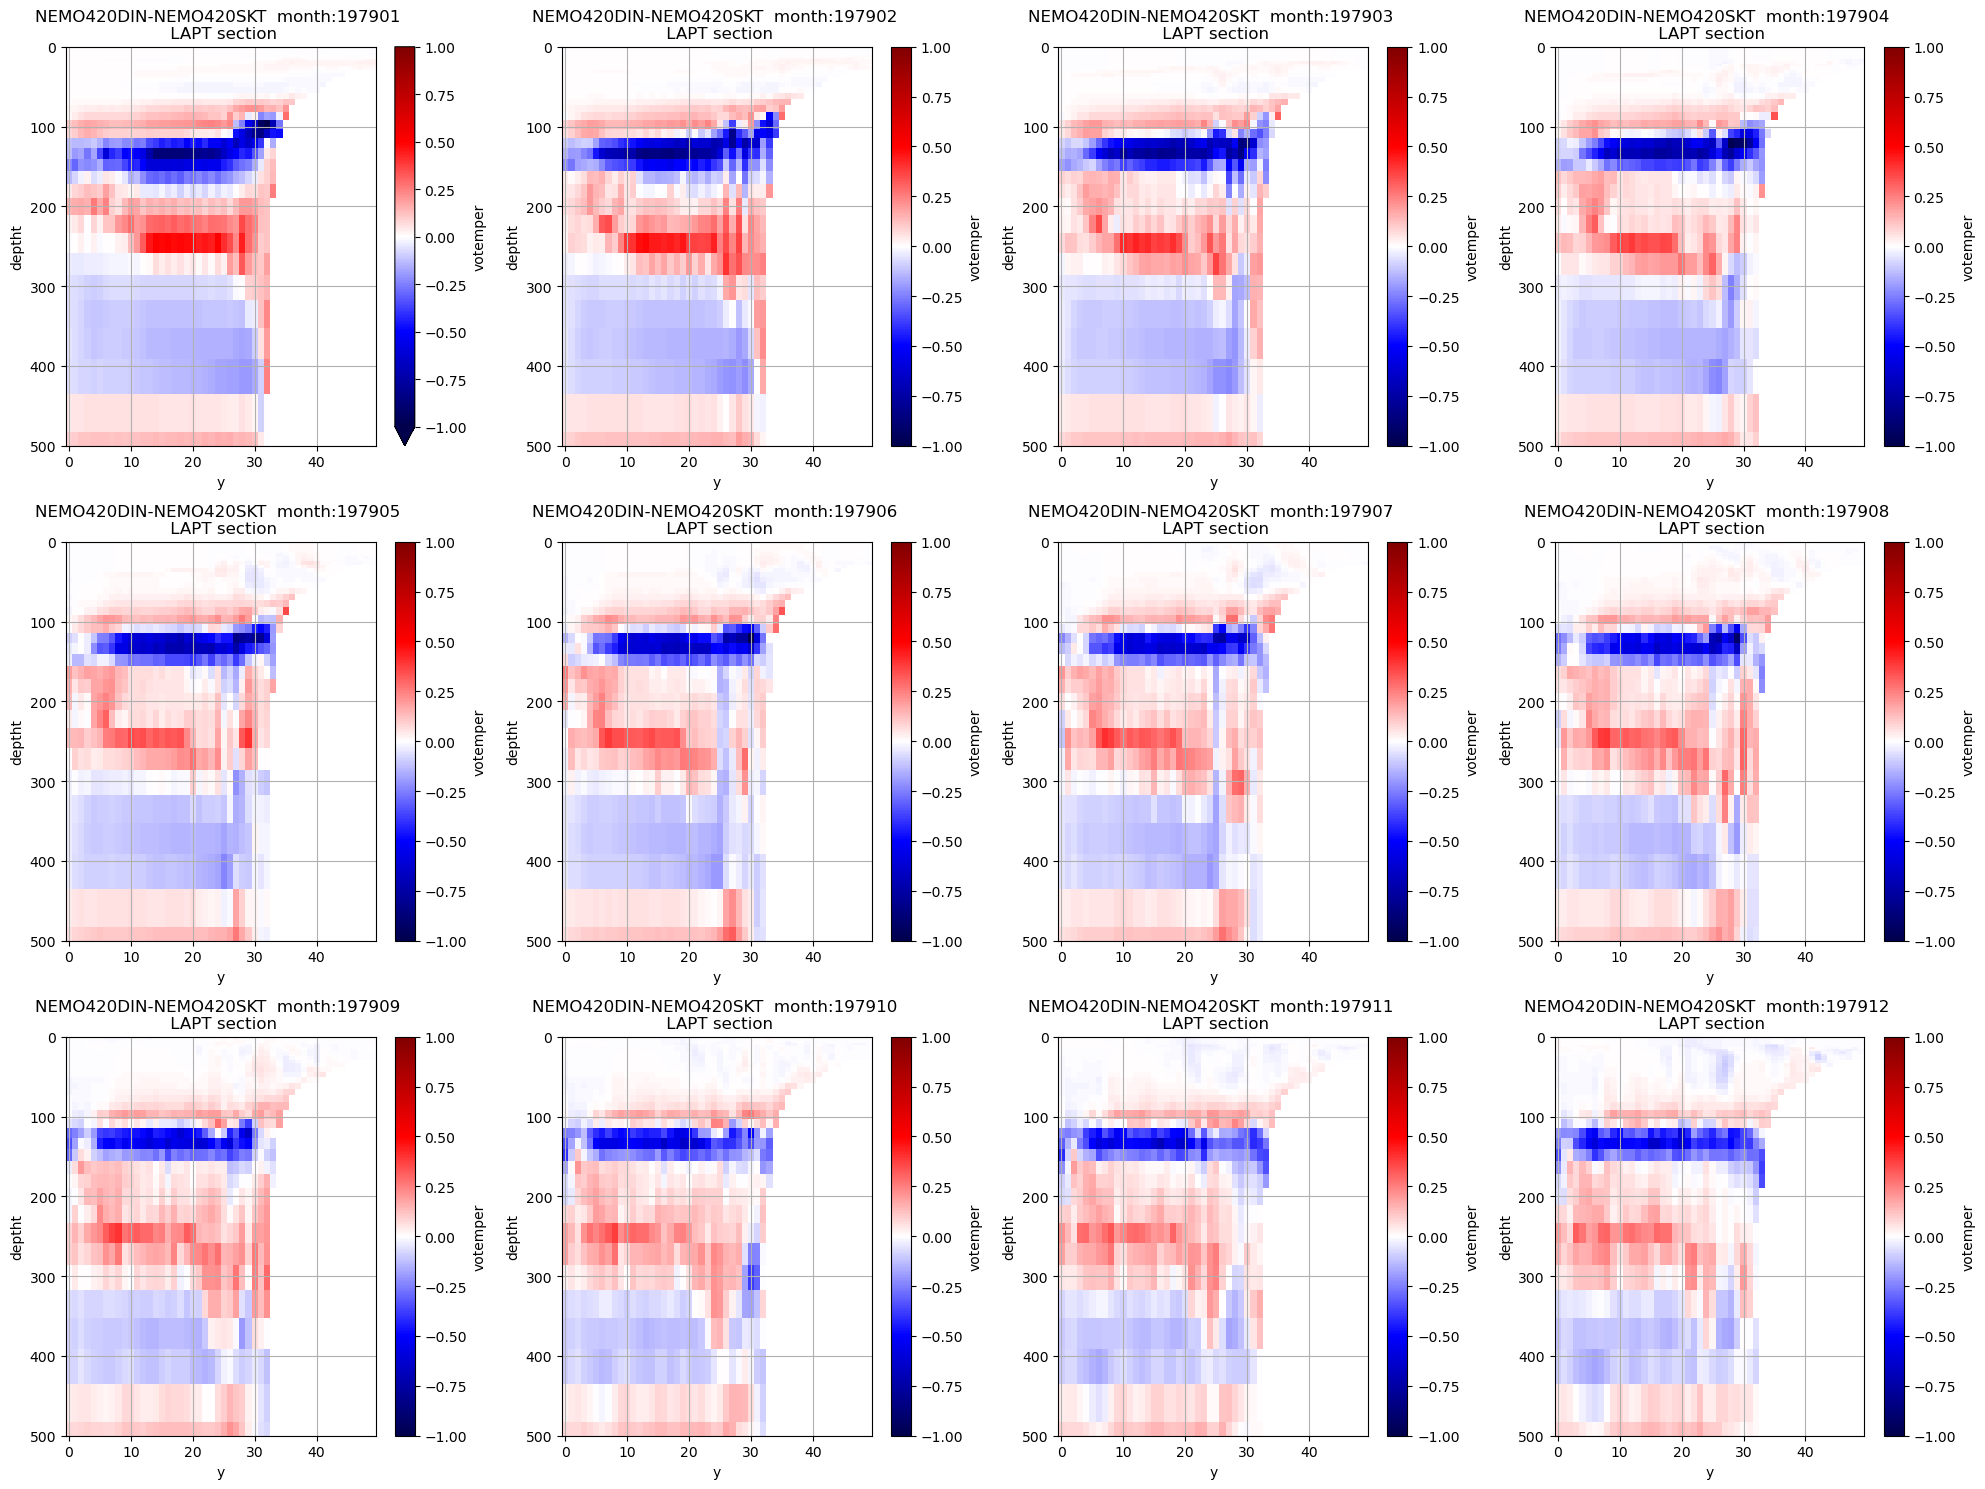

In [44]:
%%time 
CASE='NEMO420SKT'
CASE2='NEMO420DIN'
ys=1979 ; ye=1979
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE+'-MEAN/'+freq+'/'
    ds_AW = xr.concat([xr.open_dataset(f)[['votemper']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridT.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)

    DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE2+'-MEAN/'+freq+'/'
    ds_AW2 = xr.concat([xr.open_dataset(f)[['votemper']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE2+'_y'+str(year)+'m??.'+freq+'_gridT.nc')],dim='time_counter')
    ds_AW2=xr.where(tmask2D == 0., np.nan, ds_AW2)
    
    my_min=-1 ; my_max=1.
    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        i+=1 
        if i < 10: 
            mm='0'+str(i) 
        else : 
            mm=str(i)
        #(ds_AW2['votemper']-ds_AW['votemper']).sel(time_counter=str(year)+'-'+mm).isel(x=340,y=slice(470,520)).\
        (ds_AW2['votemper']-ds_AW['votemper']).sel(time_counter=str(year)+'-'+mm).isel(x=330,y=slice(470,520)).\
        plot(y='deptht',ax=ax,vmin=my_min,vmax=my_max,cmap='seismic')   
        
        ax.set_title(CASE2+'-'+CASE+'  month:'+str(year)+mm+' \n LAPT section')
        ax.set_ylim([500.,0.]) 
        ax.grid(True)

    plt.tight_layout()
    if False: plt.savefig('./FIGURES/CREG025.L75-'+CASE2+'-'+CASE+'_Zoom_T_Sec_LAPT_y'+str(year)+'.png',dpi=300)

# Plot over time and at 50m/100m depth to see the seasonality of the Kz along the LAPT section

In [34]:
%%time 
CASE='NEMO420SKT'
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE+'-MEAN/'+freq+'/'

ys=1979 ; ye=1981
tdep=50.
ds_log=None ; ds_conc=None ; ds_thi=None
for year in (np.arange(ye-ys+1)+ys): 
    print(year)
    # Read the Kz field
    ds_AW = xr.concat([xr.open_dataset(f)[['logavt']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_gridW.nc')],dim='time_counter')
    ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
    ds_IC = xr.concat([xr.open_dataset(f)[['siconc','sivolu']] for f in fs.glob(DATA_PATH+str(year)+'/'+'CREG025.L75-'+CASE+'_y'+str(year)+'m??.'+freq+'_icemod.nc')],dim='time_counter')
    ds_IC=xr.where(tmask2D == 0., np.nan, ds_IC)

    ds_logavt = ds_AW['logavt'].sel(depthw=tdep, method='nearest').isel(x=340,y=slice(470,520))
    ds_sicon = ds_IC['siconc'].isel(x=340,y=slice(470,520))
    ds_sithi = ds_IC['sivolu'].isel(x=340,y=slice(470,520))
    
    if ds_log is None:
        ds_log = ds_logavt
        ds_sic = ds_sicon
        ds_thi = ds_sithi
    else:
        ds_log = xr.concat([ds_log, ds_logavt], dim='time_counter')
        ds_sic = xr.concat([ds_sic, ds_sicon], dim='time_counter')
        ds_thi = xr.concat([ds_thi, ds_sithi], dim='time_counter')        
    
    #ds_log=xr.concat([ds_log,ds_AW['logavt'].sel(depthw=100,method='nearest').isel(y=425,x=slice(320,370))],coords='all',dim='time_counter')
    #ds_con=xr.concat([ds_con,ds_IC['siconc'].isel(y=425,x=slice(320,370))],coords='all',dim='time_counter')
    #ds_thi=xr.concat([ds_thi,ds_ICE['sivolu'].isel(y=425,x=slice(320,370))],coords='all',dim='time_counter')
    

1979
1980
1981
CPU times: user 8.68 s, sys: 6.98 s, total: 15.7 s
Wall time: 21.3 s


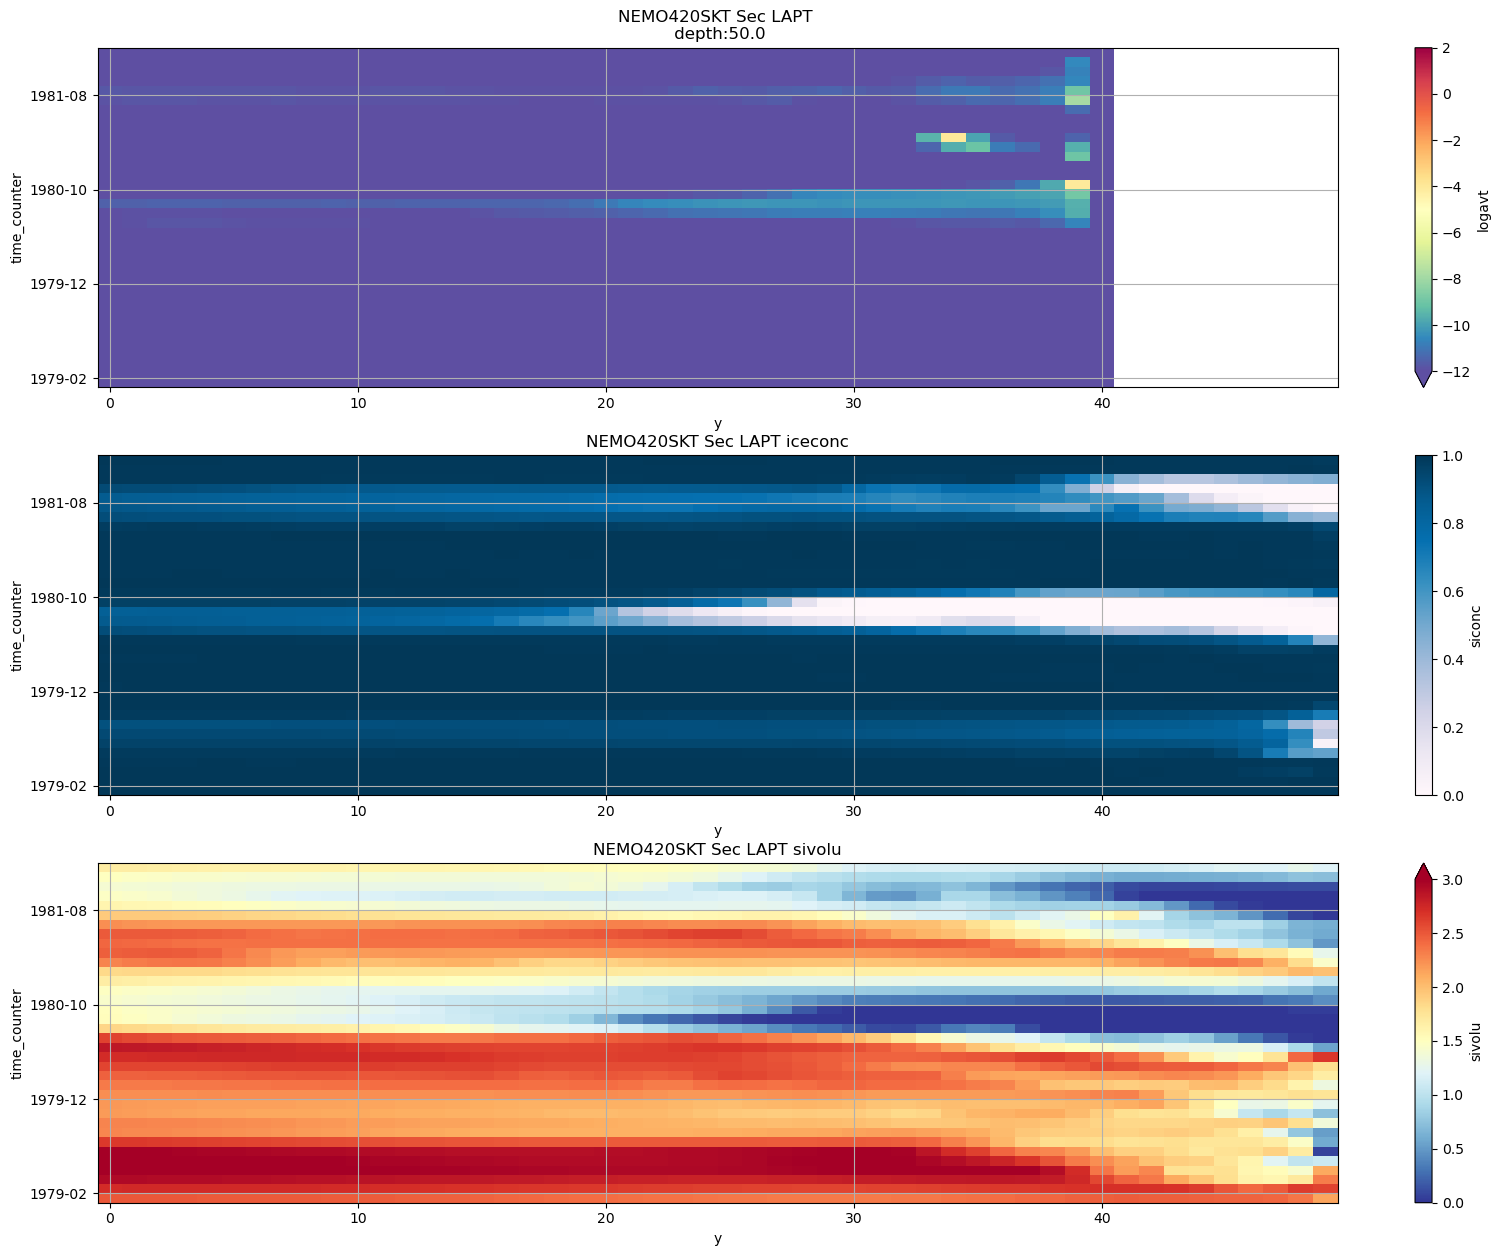

In [35]:
plt.figure(figsize=(20,15))

zdep=np.round(ds_AW['depthw'].sel(depthw=tdep,method='nearest').data)

plt.subplot(311)
ds_log_sorted = ds_log.sortby("time_counter")
my_min=-12 ; my_max=2.
ds_log_sorted.plot(y='time_counter',vmin=my_min,vmax=my_max,cmap='Spectral_r') 

plt.grid(True)
plt.title(CASE+' Sec LAPT \n depth:'+str(zdep))

plt.subplot(312)
ds_sic_sorted = ds_sic.sortby("time_counter")
ds_sic_sorted.plot(y='time_counter',vmin=0.,vmax=1.,cmap='PuBu') 

plt.grid(True)
plt.title(CASE+' Sec LAPT iceconc')

plt.subplot(313)
ds_thi_sorted = ds_thi.sortby("time_counter")
ds_thi_sorted.plot(y='time_counter',vmin=0.,vmax=3.,cmap='RdYlBu_r') 

plt.grid(True)
plt.title(CASE+' Sec LAPT sivolu')

if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_Zoom_LogAvt_Sec_LAPT_z'+str(np.round(zdep))+'_y'+str(ys)+str(ye)+'.png',dpi=300)

# Assess Kz vertical structure in the Eurasian Basin 

In [15]:
#CASE='DFS52NEM405'   ; freq='5d'
#CASE='ERA01NEM405'   ; freq='5d'
#CASE='NEMO420TTT'   ; freq='1m'
CASE='NEMO420SKT'   ; freq='1m'
#CASE='NEMO420ZMF'   ; freq='1m'


zyear=1979
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE+'-MEAN/'+freq+'/'
AW_files = [f for f in fs.glob(DATA_PATH+str(zyear)+'/'+'CREG025.L75-'+CASE+'_y'+str(zyear)+'m??.'+freq+'_gridW.nc')]     
AW_files

['/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420TTT-MEAN/1m/1979/CREG025.L75-NEMO420TTT_y1979m01.1m_gridW.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420TTT-MEAN/1m/1979/CREG025.L75-NEMO420TTT_y1979m02.1m_gridW.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420TTT-MEAN/1m/1979/CREG025.L75-NEMO420TTT_y1979m03.1m_gridW.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420TTT-MEAN/1m/1979/CREG025.L75-NEMO420TTT_y1979m04.1m_gridW.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420TTT-MEAN/1m/1979/CREG025.L75-NEMO420TTT_y1979m05.1m_gridW.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420TTT-MEAN/1m/1979/CREG025.L75-NEMO420TTT_y1979m06.1m_gridW.nc',
 '/home/datawork-lops-drakkarcom/SIMULAT

ds_AW shape:  <xarray.Dataset>
Dimensions:        (time_counter: 132, depthw: 75, y: 603, x: 528)
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
  * depthw         (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    time_centered  (time_counter) object dask.array<chunksize=(4,), meta=np.ndarray>
  * time_counter   (time_counter) object 1979-01-16 12:00:00 ... 1989-12-16 1...
Dimensions without coordinates: y, x
Data variables:
    logavt         (time_counter, depthw, y, x) float32 dask.array<chunksize=(4, 75, 603, 528), meta=np.ndarray>
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-NEMO420TTT-XIOS.1/...
    description:       ocean W grid variables
    title:             ocean W grid variables
    Conventions:       CF-1.6
    timeStamp:         2024-Feb-09 22:10:35 GMT
    uuid:              e64815d7-5c31-433b-8ff5-408e2

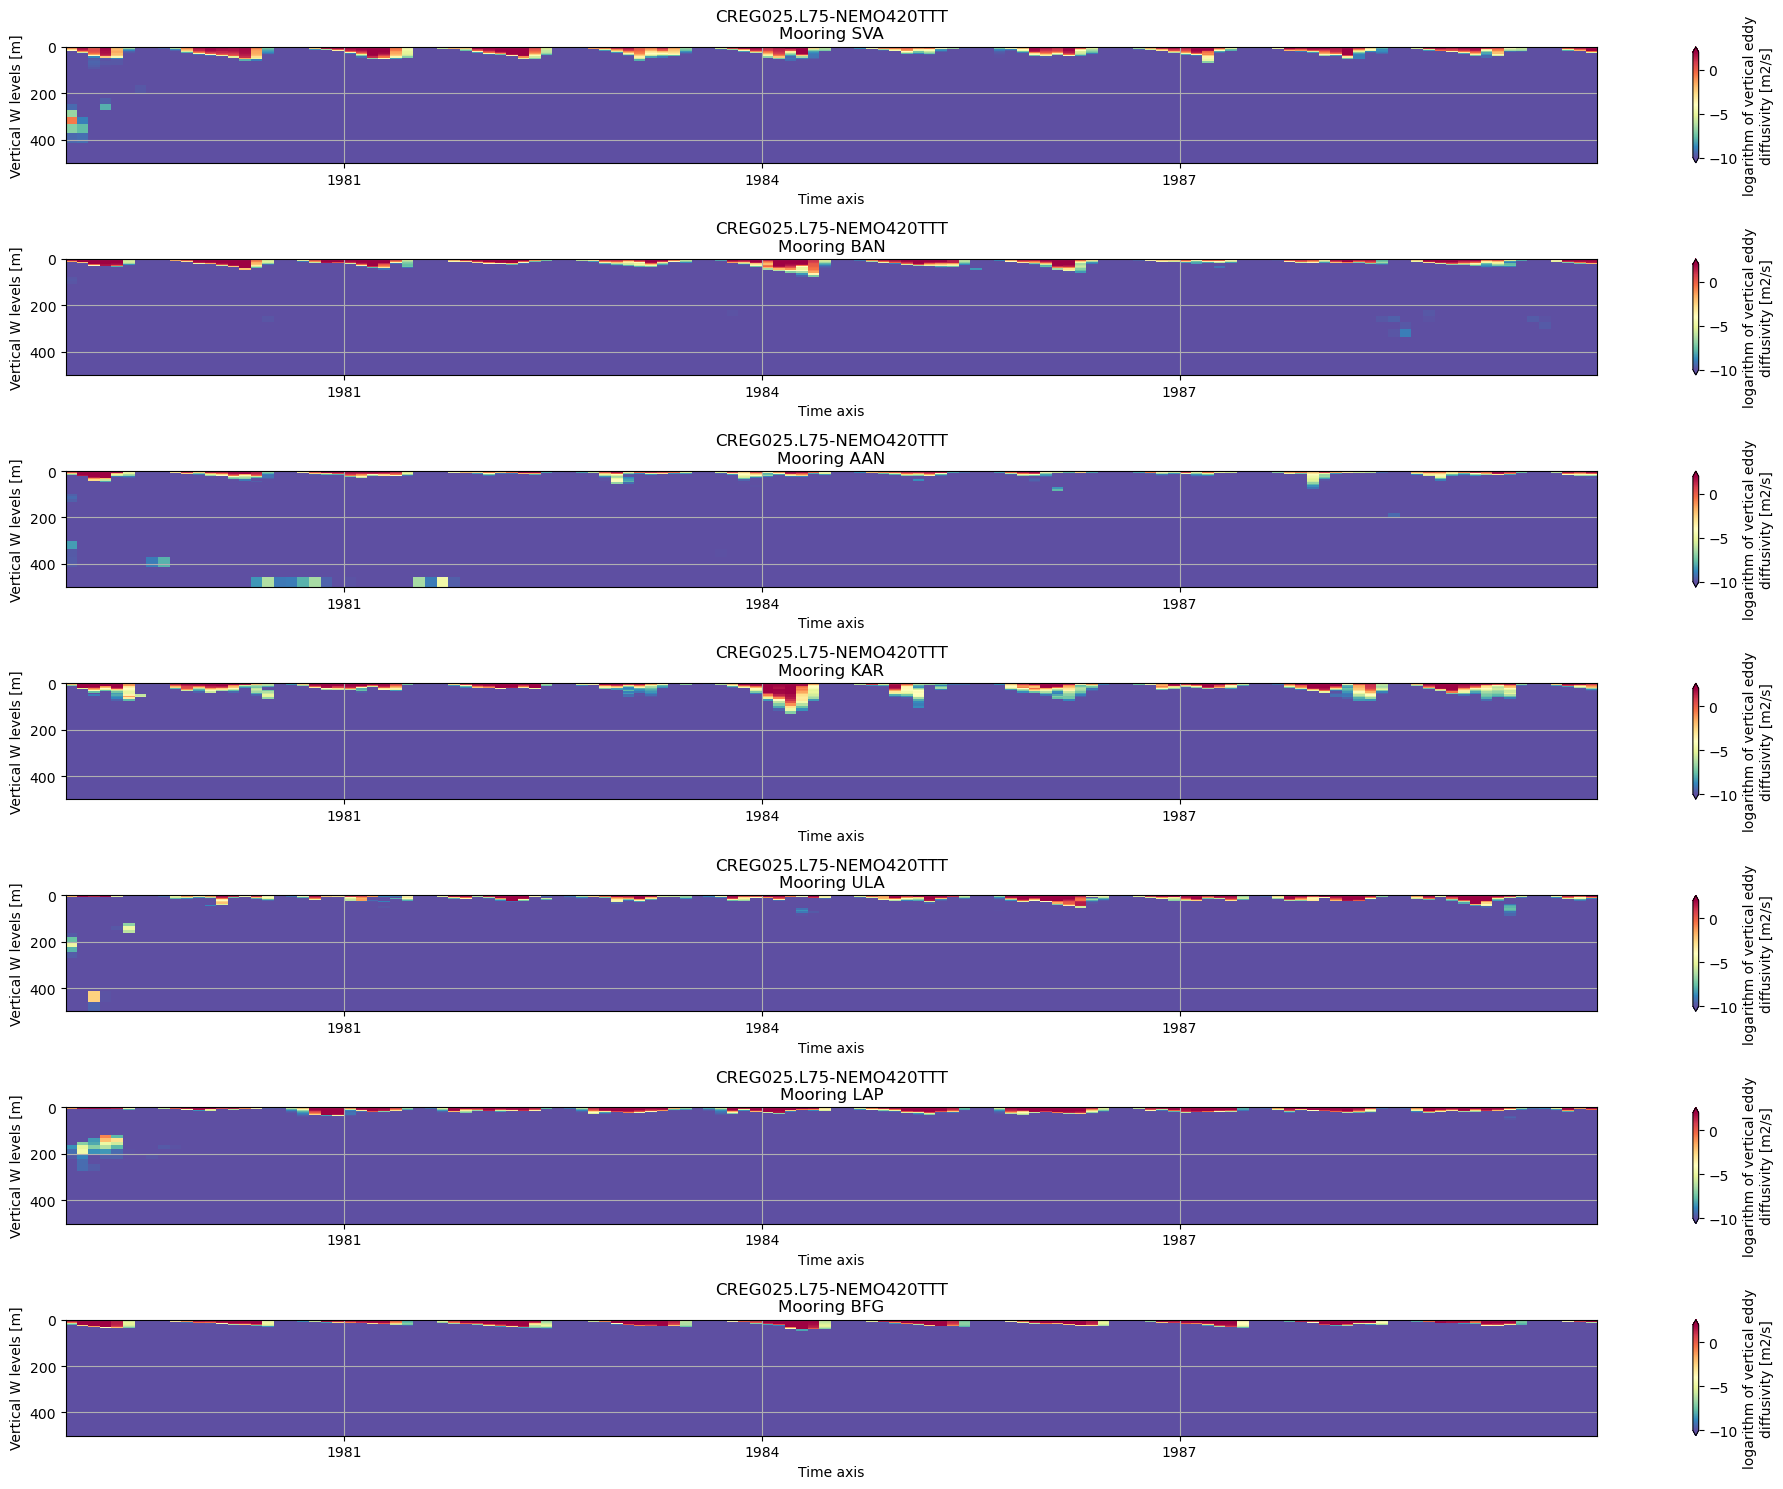

In [16]:
%%time 
loc=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR]
ys=1979 ; ye=1989
lst_years=np.arange(ye-ys+1)+ys
file_ext='z0-500m'

# Read the gridW file
ds_AW = xr.concat([ xr.open_dataset(f)[['logavt']]  \
                   for lyear in lst_years \
                   for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE+'_y'+str(lyear)+'m??.'+freq+'_gridW.nc')],\
                  dim='time_counter')
# Apply a treshold below which the value are just masked
minlog=-10.
#ds_AW=xr.where(ds_AW < minlog, np.nan, ds_AW)
ds_AW=ds_AW.chunk({'time_counter':4})
print('ds_AW shape: ',ds_AW)

fig, axes=plt.subplots(len(loc),1,figsize=(20,15))
for i, ax in enumerate(axes.flat):
    ds_AW['logavt'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max']).plot(x='time_counter', y='depthw', \
                                                                     vmin=minlog,vmax=2., \
                                                                     cmap='Spectral_r',
                                                                     ax=ax)
    ax.invert_yaxis()  
    if file_ext == 'z0-500m':
        ax.set_ylim([500.,0.])    
    else: 
        ax.set_ylim([1000.,0.])    
    ax.set_title('CREG025.L75-'+CASE+'\n'+'Mooring '+loc[i]['name'])
    ax.grid(True)

plt.tight_layout()
if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_LogAvt_TiSe_Moor_'+file_ext+'_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)

# Plot on a map the mooring location

In [38]:
bx_SVAL={'name':'SVA','lon_min':325,'lon_max':325,'lat_min':350,'lat_max':350,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BANN={'name':'BAN','lon_min':347,'lon_max':347,'lat_min':400,'lat_max':400,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_AANN={'name':'AAN','lon_min':354,'lon_max':354,'lat_min':425,'lat_max':425,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_KARA={'name':'KAR','lon_min':355,'lon_max':355,'lat_min':450,'lat_max':450,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_ULAP={'name':'ULA','lon_min':364,'lon_max':364,'lat_min':478,'lat_max':478,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BGYR={'name':'BFG','lon_min':200,'lon_max':200,'lat_min':500,'lat_max':500,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_GINS={'name':'GIN','lon_min':355,'lon_max':355,'lat_min':310,'lat_max':310,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_MIKE={'name':'MIB','lon_min':356,'lon_max':356,'lat_min':237,'lat_max':237,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}

In [42]:
LAPT_sec={'name':"Laptev" ,'jmin': 470,'jmax':520 ,'imin':340}
SANX_sec={'name':"Saint Anna",'imin': 320,'imax':370 ,'jmax':425}
LAPZ_sec={'name':"Laptev east" ,'jmin': 470,'jmax':520 ,'imin':330}

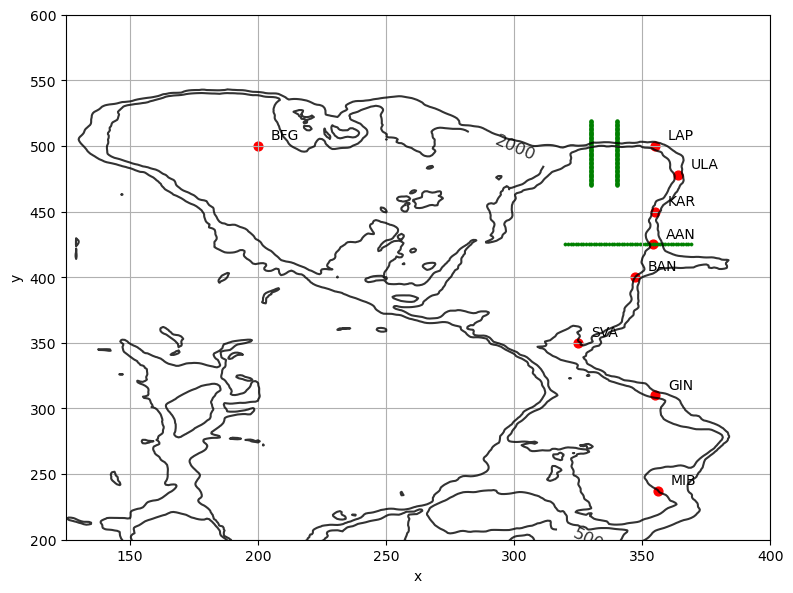

In [43]:
plt.figure(figsize=(20,15))
plt.subplot(221)
CS=fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.8)
plt.clabel(CS,fontsize=12)
plt.ylim([200,600])
plt.xlim([125,400])
All_box=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR,bx_GINS,bx_MIKE]
for box in All_box:
    plt.scatter(box['lon_min'],box['lat_min'],40,marker='o', color='r')
    plt.text(box['lon_min']+5,box['lat_min']+5,box['name'])
plt.grid(True)
# Plot the sections
if True:
    All_sec=[SANX_sec]
    for box in All_sec:
            #################
            # ZONAL SECTIONS
            #################
            ji=box['imin'] ;   jj=box['jmax']
            while ji <= box['imax']-1 :
                    plt.scatter(ji,jj,5,linewidth=0.5,color='g')
                    ji+=1

    All_sec=[LAPT_sec,LAPZ_sec]
    for box in All_sec:
            #################
            # MERIDIONAL SECTIONS
            #################
            jj=box['jmin'] ;       ji=box['imin']
            while jj <= box['jmax']-1 :
                    plt.scatter(ji,jj,5,linewidth=1,color='g')
                    jj+=1
